In [1]:
### import collections
import json
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from mab import algs


class ONN(nn.Module):
    def __init__(self, features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, batch_size=1,
                 b=0.99, n=0.01, s=0.2, use_cuda=False):
        super(ONN, self).__init__()

        if torch.cuda.is_available() and use_cuda:
            print("Using CUDA :]")

        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")

        self.features_size = features_size
        self.max_num_hidden_layers = max_num_hidden_layers
        self.qtd_neuron_per_hidden_layer = qtd_neuron_per_hidden_layer
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.b = Parameter(torch.tensor(
            b), requires_grad=False).to(self.device)
        self.n = Parameter(torch.tensor(
            n), requires_grad=False).to(self.device)
        self.s = Parameter(torch.tensor(
            s), requires_grad=False).to(self.device)

        self.hidden_layers = []
        self.output_layers = []

        self.hidden_layers.append(
            nn.Linear(features_size, qtd_neuron_per_hidden_layer))

        for i in range(max_num_hidden_layers - 1):
            self.hidden_layers.append(
                nn.Linear(qtd_neuron_per_hidden_layer, qtd_neuron_per_hidden_layer))

        for i in range(max_num_hidden_layers):
            self.output_layers.append(
                nn.Linear(qtd_neuron_per_hidden_layer, n_classes))

        self.hidden_layers = nn.ModuleList(self.hidden_layers).to(self.device)
        self.output_layers = nn.ModuleList(self.output_layers).to(self.device)

        self.alpha = Parameter(torch.Tensor(self.max_num_hidden_layers).fill_(1 / (self.max_num_hidden_layers + 1)),
                               requires_grad=False).to(
            self.device)

        self.loss_array = []
        self.tp=0.1
        self.tn=0.1
        self.fp=0.1
        self.fn=0.1
        self.bal_acc = 0
        self.bal_acc_list = []
        self.sen = 0
        self.spec = 0
        
        self.protected_pos = 0.1
        self.protected_neg = 0.1
        self.non_protected_pos = 0.1
        self.non_protected_neg = 0.1
        self.stp_score=0
        
        self.tp_protected = 0.1
        self.fn_protected = 0.1
        self.tp_non_protected = 0.1
        self.fn_non_protected = 0.1
        self.eqop_score=0

    def zero_grad(self):
        for i in range(self.max_num_hidden_layers):
            self.output_layers[i].weight.grad.data.fill_(0)
            self.output_layers[i].bias.grad.data.fill_(0)
            self.hidden_layers[i].weight.grad.data.fill_(0)
            self.hidden_layers[i].bias.grad.data.fill_(0)

    def update_weights(self, X, Y, weight, show_loss, test):
        Y = torch.from_numpy(Y).to(self.device)
        if test=='yes':
            prediction_1 = self.predict_1(X)
            self.update_eval_metrics(prediction_1,Y)
            self.update_stp_score(prediction_1,X)
            self.update_eqop_score(prediction_1,X,Y)
        
        predictions_per_layer = self.forward(X)
        losses_per_layer = []

        for out in predictions_per_layer:
            criterion = nn.CrossEntropyLoss().to(self.device)
            loss = criterion(out.view(self.batch_size, self.n_classes), Y.view(
                self.batch_size).long())
            losses_per_layer.append(loss*weight)

        w = [None] * len(losses_per_layer)
        b = [None] * len(losses_per_layer)
        
        with torch.no_grad():     #Context-manager that disabled gradient calculation
            self.weights_output_layers = list()
            self.biases_output_layers = list()
            for i in range(len(losses_per_layer)):
                losses_per_layer[i].backward(retain_graph=True)
                self.output_layers[i].weight.data -= self.n * \
                                                   self.alpha[i] * self.output_layers[i].weight.grad.data
                self.output_layers[i].bias.data -= self.n * \
                                                 self.alpha[i] * self.output_layers[i].bias.grad.data
                self.weights_output_layers.append(self.output_layers[i].weight.data) 
                self.biases_output_layers.append(self.output_layers[i].bias.data)
                
                for j in range(i + 1):
                    if w[j] is None:
                        w[j] = self.alpha[i] * self.hidden_layers[j].weight.grad.data
                        b[j] = self.alpha[i] * self.hidden_layers[j].bias.grad.data
                    else:
                        w[j] += self.alpha[i] * self.hidden_layers[j].weight.grad.data
                        b[j] += self.alpha[i] * self.hidden_layers[j].bias.grad.data
                self.zero_grad()
            self.weights_hidden_layers= list()
            self.biases_hidden_layers = list()
            
            for i in range(len(losses_per_layer)):
                self.hidden_layers[i].weight.data -= self.n * w[i]
                self.hidden_layers[i].bias.data -= self.n * b[i]
                self.weights_hidden_layers.append(self.hidden_layers[i].weight.data)
                self.biases_hidden_layers.append(self.hidden_layers[i].bias.data)
            for i in range(len(losses_per_layer)):
                self.alpha[i] *= torch.pow(self.b, losses_per_layer[i])
                self.alpha[i] = torch.max(
                  self.alpha[i], self.s / self.max_num_hidden_layers)

        z_t = torch.sum(self.alpha)

        self.alpha = Parameter(
            self.alpha / z_t, requires_grad=False).to(self.device)
        if show_loss:
            
            real_output = torch.sum(torch.mul(
                self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, self.batch_size).view(
                    self.max_num_hidden_layers, self.batch_size, 1), predictions_per_layer), 0)
            criterion = nn.CrossEntropyLoss().to(self.device)
            loss = criterion(real_output.view(self.batch_size, self.n_classes), Y.view(self.batch_size).long())
            self.loss_array.append(loss)
            if (len(self.loss_array) % 1000) == 0:
                #print("WARNING: Set 'show_loss' to 'False' when not debugging. "
                #      "It will deteriorate the fitting performance.")
                loss = torch.Tensor(self.loss_array).mean().cpu().numpy()
                #print("Alpha:" + str(self.alpha.data.cpu().numpy()))
                print("Training Loss: " + str(loss))
                print("Balanced accuracy: " + str(self.bal_acc))
                print("Sensitivity: " + str(self.sen))
                print("Specificity: " + str(self.spec))
                print("Stp score: " + str(self.stp_score))
                print("Eqop score: " + str(self.eqop_score))
                self.loss_array.clear()

    def get_weights(self,network_name):
        
        if network_name == 'global':
            weights_output_layers = list()
            biases_output_layers = list()
            weights_hidden_layers = list()
            biases_hidden_layers= list()
            for i in range(self.max_num_hidden_layers):
                weights_output_layers.append(self.output_layers[i].weight.data) 
                biases_output_layers.append(self.output_layers[i].bias.data)
                weights_hidden_layers.append(self.hidden_layers[i].weight.data)
                biases_hidden_layers.append(self.hidden_layers[i].bias.data)
               
            return self.alpha, weights_output_layers, biases_output_layers, weights_hidden_layers, biases_hidden_layers
        else:
            return self.alpha, self.weights_output_layers, self.biases_output_layers, self.weights_hidden_layers, self.biases_hidden_layers
    
    def set_weights(self, alpha, w_output_layer, b_output_layer, w_hidden_layer, b_hidden_layer):
        
        for i in range(self.max_num_hidden_layers):
            self.alpha[i] = alpha[i].clone().detach()
            self.output_layers[i].weight.data = w_output_layer[i].clone().detach()
            self.output_layers[i].bias.data = b_output_layer [i].clone().detach()
            self.hidden_layers[i].weight.data =  w_hidden_layer [i].clone().detach()
            self.hidden_layers[i].bias.data = b_hidden_layer [i].clone().detach()    
    def forward(self, X):
        hidden_connections = []

        X = torch.from_numpy(X).float().to(self.device)

        x = F.relu(self.hidden_layers[0](X))
        hidden_connections.append(x)

        for i in range(1, self.max_num_hidden_layers):
            hidden_connections.append(
                F.relu(self.hidden_layers[i](hidden_connections[i - 1])))

        output_class = []

        for i in range(self.max_num_hidden_layers):
            output_class.append(self.output_layers[i](hidden_connections[i]))

        pred_per_layer = torch.stack(output_class)

        return pred_per_layer

    def validate_input_X(self, data):
        
        if len(data.shape) != 2:
            raise Exception(
                "Wrong dimension for this X data. It should have only two dimensions.")

    def validate_input_Y(self, data):
        if len(data.shape) != 1:
            raise Exception(
                "Wrong dimension for this Y data. It should have only one dimensions.")

    def partial_fit_(self, X_data, Y_data, weight, show_loss=True, test='yes'):
        
        self.validate_input_X(X_data)
        self.validate_input_Y(Y_data)
        self.update_weights(X_data, Y_data, weight, show_loss, test)

    def partial_fit(self, X_data, Y_data, weight, show_loss=True, test='yes'):
        
        self.partial_fit_(X_data, Y_data, weight, show_loss, test)

    def reset_eval_metrics(self):
        self.tp=0.1
        self.tn=0.1
        self.fp=0.1
        self.fn=0.1
        self.bal_acc = 0
        self.bal_acc_list = []
        self.sen = 0
        self.spec = 0
        
        self.protected_pos = 0.1
        self.protected_neg = 0.1
        self.non_protected_pos = 0.1
        self.non_protected_neg = 0.1
        self.stp_score=0
        
        self.tp_protected = 0.1
        self.fn_protected = 0.1
        self.tp_non_protected = 0.1
        self.fn_non_protected = 0.1
        self.eqop_score=0
    def update_eval_metrics(self,prediction_1,Y):
        if prediction_1==1 and Y==1:
            self.tp+=1
        elif prediction_1==1 and Y==0:
            self.fp+=1
        elif prediction_1==0 and Y==1:
            self.fn+=1
        else:
            self.tn+=1
        
        self.sen = self.tp/(self.tp + self.fn)
        self.spec= self.tn/(self.tn + self.fp)
        self.bal_acc = (self.sen + self.spec)/2
        self.bal_acc_list.append(self.bal_acc)
            
    def update_stp_score(self,prediction_1,X):
        if X[0][sa_index] == p_Group:
            if prediction_1 == 1:
                self.protected_pos += 1.
            else:
                self.protected_neg += 1.
        else:
            if prediction_1 == 1:
                self.non_protected_pos += 1.
            else:
                self.non_protected_neg += 1.
            
        C_prot = (self.protected_pos) / (self.protected_pos + self.protected_neg)
        C_non_prot = (self.non_protected_pos) / (self.non_protected_pos + self.non_protected_neg)

        self.stp_score = C_non_prot - C_prot
    
    def update_eqop_score(self,prediction_1,X,Y):
        if X[0][sa_index] == p_Group:
            if prediction_1==1 and Y==1:
                self.tp_protected += 1.
            elif prediction_1==0 and Y==1:
                self.fn_protected += 1.
        else:
            if prediction_1==1 and Y==1:
                self.tp_non_protected += 1.
            elif prediction_1==0 and Y==1:
                self.fn_non_protected += 1.
            
        tpr_protected = self.tp_protected / (self.tp_protected + self.fn_protected)
        tpr_non_protected = self.tp_non_protected / (self.tp_non_protected + self.fn_non_protected)
        self.eqop_score = tpr_non_protected - tpr_protected
    
    def predict_1(self, X_data):
        self.validate_input_X(X_data)
        return torch.argmax(torch.sum(torch.mul(
            self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, 1).view(
                self.max_num_hidden_layers, len(X_data), 1), self.forward(X_data)), 0), dim=1).cpu().numpy()
    def predict_(self, X_data):
        self.validate_input_X(X_data)
        return torch.argmax(torch.sum(torch.mul(
            self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, len(X_data)).view(
                self.max_num_hidden_layers, len(X_data), 1), self.forward(X_data)), 0), dim=1).cpu().numpy()

    def predict(self, X_data):
        pred = self.predict_(X_data)
        return pred

    def export_params_to_json(self):
        state_dict = self.state_dict()
        params_gp = {}
        for key, tensor in state_dict.items():
            params_gp[key] = tensor.cpu().numpy().tolist()

        return json.dumps(params_gp)

    def load_params_from_json(self, json_data):
        params = json.loads(json_data)
        o_dict = collections.OrderedDict()
        for key, tensor in params.items():
            o_dict[key] = torch.tensor(tensor).to(self.device)
        self.load_state_dict(o_dict)


class ONN_THS(ONN):
    def __init__(self, features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, b=0.99, n=0.01,
                 s=0.2, e=[0.5, 0.35, 0.2, 0.1, 0.05], use_cuda=False):
        super().__init__(features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, b=b, n=n, s=s,
                         use_cuda=use_cuda)
        self.e = Parameter(torch.tensor(e), requires_grad=False)
        self.arms_values = Parameter(
            torch.arange(n_classes), requires_grad=False)
        self.explorations_mab = []

        for i in range(n_classes):
            self.explorations_mab.append(algs.ThompsomSampling(len(e)))

    def partial_fit(self, X_data, Y_data, exp_factor, show_loss=True):
        self.partial_fit_(X_data, Y_data, show_loss)
        self.explorations_mab[Y_data[0]].reward(exp_factor)

    def predict(self, X_data):
        pred = self.predict_(X_data)[0]
        exp_factor = self.explorations_mab[pred].select()[0]
        if np.random.uniform() < self.e[exp_factor]:
            removed_arms = self.arms_values.clone().numpy().tolist()
            removed_arms.remove(pred)
            return random.choice(removed_arms), exp_factor

        return pred, exp_factor


In [2]:
from sklearn.datasets import make_classification, make_circles
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from imblearn.datasets import make_imbalance
import numpy as np

In [3]:
# import urllib2
# import urllib2
import os, sys
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle

# import utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)


def load_law():
    FEATURES_CLASSIFICATION = ["decile1b", "decile3", "lsat", "ugpa", "zfygpa","zgpa", "fulltime", "fam_inc", "sex", "race", "tier"]  # features to be used for classification
    CONT_VARIABLES = ["lsat", "ugpa", "zfygpa", "zgpa"]  # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
    CLASS_FEATURE = "y"  # the decision variable
    SENSITIVE_ATTRS = ["sex"]
    CAT_VARIABLES = ["decile1b", "decile3", "fulltime", "fam_inc", "sex", "race", "tier"]
    CAT_VARIABLES_INDICES = [1,2,7,8,9,10,11]
    # COMPAS_INPUT_FILE = "bank-full.csv"
    INPUT_FILE = "./datasets/law.csv"

    df = pd.read_csv(INPUT_FILE)
    
    # convert to np array
    data = df.to_dict('list')
    print(data.keys())
    for k in data.keys():
        data[k] = np.array(data[k])

    """ Feature normalization and one hot encoding """

    # convert class label 0 to -1
    y = data[CLASS_FEATURE]
    #print(np.unique(y))
    #y[y == 0] = 1
    #y[y==0] = -1
    #y[y == 1] = -1
    y = np.array([int(k) for k in y])

    X = np.array([]).reshape(len(y), 0)  # empty array with num rows same as num examples, will hstack the features to it
    
    x_control = defaultdict(list)
    i=0
    feature_names = []
    
    for attr in FEATURES_CLASSIFICATION:
        vals = data[attr]
        
        if attr in CONT_VARIABLES:
            vals = [float(v) for v in vals]
            vals = preprocessing.scale(vals)  # 0 mean and 1 variance
            vals = np.reshape(vals, (len(y), -1))  # convert from 1-d arr to a 2-d arr with one col
            

        else:  # for binary categorical variables, the label binarizer uses just one var instead of two
            lb = preprocessing.LabelBinarizer()
            lb.fit(vals)
            vals = lb.transform(vals)
           
            if attr == 'sex':
                print(lb.classes_)
                print(lb.transform(lb.classes_))
            
           
            
            
        # add to sensitive features dict
        if attr in SENSITIVE_ATTRS:
            x_control[attr] = vals
            

        # add to learnable features
        X = np.hstack((X, vals))
        
        if attr in CONT_VARIABLES:  # continuous feature, just append the name
            feature_names.append(attr)
        else:  # categorical features
            if vals.shape[1] == 1:  # binary features that passed through lib binarizer
                feature_names.append(attr)
            else:
                for k in lb.classes_:  # non-binary categorical features, need to add the names for each cat
                    feature_names.append(attr + "_" + str(k))

    # convert the sensitive feature to 1-d array
    
    x_control = dict(x_control)
    
    for k in x_control.keys():
        assert (x_control[k].shape[1] == 1)  # make sure that the sensitive feature is binary after one hot encoding
        x_control[k] = np.array(x_control[k]).flatten()
    
    feature_names.append('target')
    
   
    print(feature_names)
    return X, y, feature_names.index(SENSITIVE_ATTRS[0]), 1, x_control

X,y, sa_index, p_Group, x_control= load_law()

#print(X[0])
#print(X[0][1])
#print(sa_index)
np_Group = 0 #non-protected group's sa_value
Y = []
for i in y:
    if (i == 0):
        Y.append(1)
    else:
        Y.append(0)
        
y = np.array(Y)
#from sklearn.utils import shuffle
#X_1, Y_1 = shuffle(X_1, Y_1)
#X, x_test, Y, y_test = train_test_split(X_1,Y_1, test_size=0.2)

dict_keys(['decile1b', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'fulltime', 'fam_inc', 'sex', 'race', 'tier', 'y'])
[0 1]
[[0]
 [1]]
['decile1b_1', 'decile1b_2', 'decile1b_3', 'decile1b_4', 'decile1b_5', 'decile1b_6', 'decile1b_7', 'decile1b_8', 'decile1b_9', 'decile1b_10', 'decile3_1', 'decile3_2', 'decile3_3', 'decile3_4', 'decile3_5', 'decile3_6', 'decile3_7', 'decile3_8', 'decile3_9', 'decile3_10', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'fulltime', 'fam_inc_1', 'fam_inc_2', 'fam_inc_3', 'fam_inc_4', 'fam_inc_5', 'sex', 'race', 'tier_1', 'tier_2', 'tier_3', 'tier_4', 'tier_5', 'tier_6', 'target']


In [4]:
COMPAS_INPUT_FILE = "./datasets/law.csv"

df = pd.read_csv(COMPAS_INPUT_FILE)
age_group_1 = []
age_group_2 = []
age_group_3 = []
for i in range(len(df)):
    if df['fam_inc'].iloc[i]>=1 and df['fam_inc'].iloc[i]<=2:
        age_group_1.append(i)
    elif df['fam_inc'].iloc[i]>=4 and df['fam_inc'].iloc[i]<=5:
        age_group_2.append(i)
    elif df['fam_inc'].iloc[i]==3:
        age_group_3.append(i)


In [5]:
Xtr1 = np.empty((0,0))
Ytr1 = np.empty(0)
for i in age_group_1:
    if np.size(Xtr1)==0:
        print("bismillah")
        Xtr1 = X[i]
        Ytr1 = y[i]
    else:
        Xtr1 = np.vstack((Xtr1,X[i]))
        Ytr1 = np.append(Ytr1,y[i])

Xtr2 = np.empty((0,0))
Ytr2 = np.empty(0)
for i in age_group_2:
    if np.size(Xtr2)==0:
        print("bismillah")
        Xtr2 = X[i]
        Ytr2 = y[i]
    else:
        Xtr2 = np.vstack((Xtr2,X[i]))
        Ytr2 = np.append(Ytr2,y[i])
        
Xtr3 = np.empty((0,0))
Ytr3 = np.empty(0)
for i in age_group_3:
    if np.size(Xtr3)==0:
        print("bismillah")
        Xtr3 = X[i]
        Ytr3 = y[i]
    else:
        Xtr3 = np.vstack((Xtr3,X[i]))
        Ytr3 = np.append(Ytr3,y[i])
print(len(Xtr3))
print(len(Ytr3))
print(Ytr3)

bismillah
bismillah
bismillah
6683
6683
[0 0 0 ... 0 0 0]


In [6]:
print(len(X))
print(len(age_group_1))

18692
1977


In [7]:
clients = {}
client_data_testx = []
client_data_testy = []
x_train, x_test, y_train, y_test = train_test_split(Xtr1,Ytr1,test_size=0.2)
Xtr1 = x_train
Xte1 = x_test
Ytr1 = y_train
Yte1 = y_test
Xtr = x_train
client_data_testx.append(Xte1)
client_data_testy.append(Yte1)
####
x_train, x_test, y_train, y_test = train_test_split(Xtr2,Ytr2,test_size=0.2)
Xtr2 = x_train
Xte2 = x_test
Ytr2 = y_train
Yte2 = y_test
client_data_testx.append(Xte2)
client_data_testy.append(Yte2)
####
x_train, x_test, y_train, y_test = train_test_split(Xtr3,Ytr3,test_size=0.2)
Xtr3 = x_train
Xte3 = x_test
Ytr3 = y_train
Yte3 = y_test
client_data_testx.append(Xte3)
client_data_testy.append(Yte3)
####

#client_data_testx.append(Xte4)
#client_data_testy.append(Yte4)


In [8]:
#concatnate teset data
x_test_new = np.concatenate((client_data_testx[0], client_data_testx[1]), axis=0)
x_test_new = np.concatenate((x_test_new, client_data_testx[2]), axis=0)
y_test_new = np.concatenate((client_data_testy[0], client_data_testy[1]), axis=0)
y_test_new = np.concatenate((y_test_new, client_data_testy[2]), axis=0)
#test_batched1 = tf.data.Dataset.from_tensor_slices((x_test_new, y_test_new)).batch(len(y_test_new))
x_test = x_test_new
y_test = y_test_new

In [9]:
print(np.unique(y))
list(y).count(1)

[0 1]


1836

In [10]:
def k_nearest_neighbors(data, predict, k):
    #k=8
    #if len(data) >= k:
    #    warnings.warn('K is set to a value less than total voting groups!')

    distances = []
    count = 0
    for sample in data:
        euclidean_distance = np.linalg.norm(np.array(sample)-np.array(predict))
        distances.append([euclidean_distance,count])
        count+=1
    
    votes = [i[1] for i in sorted(distances)[:k]] ##votes is returning indexes of k random samples

    #vote_result = Counter(votes).most_common(9)[0][0]
    return votes
def fair_kSMOTE_algo_2(dmajor,dminor,k,r):
    S = []
    Ns =  int(r*(len(dmajor)))
    #Ns = 12
    Nks = int(Ns / (k-1))
    difference = Ns-Nks*(k-1)
    
    rb = []
    #pick a random k sample from dmin and save them in rb
    dmin_rand = random.sample(dminor, k-1)   
    #for debugging
    sens_attr_vals = []
    i = 0
    
    #do algorithem (choose the nearest neighbor and linear interpolation)
    for xb in dmin_rand:
        N= k_nearest_neighbors(dminor,xb,k) #from minority-p
        
        #do linear interpolation
        Sxb = []
        
        if i==0:
            Nkss = Nks+difference
        else:
            Nkss = Nks
        
        i+=1
        for s in range(Nkss):
            
            
            j = 1  ##?? j?
            #randome k sample
            #j = random.randint(0, len(N))
            
            ##here nearst neghber insted of dminor
            #linear interpolation
            x_new = ((dminor[N[j]]-xb) * random.sample(range(0, 1), 1))
            j+=1
            
            while(j < len(N)):
                #here on random xb
                ind = N[j]
                x_new = x_new + ((dminor[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1
                
            x_new = x_new / (len(N)-1) ##??? why scaling with k here
            Synthesized_instance = xb + x_new ##?> why we need to sum xb and x_new
            
            
            #for algo 3 when finding nearest neighbors from min_np and assigning the 
            #'p' sensitive value to all synthesized instances
            Synthesized_instance[sa_index] = xb[sa_index] 
            Sxb.append(Synthesized_instance)
        
            
            
            
            
        S.append(Sxb)
    
    
    
    return S

def fair_kSMOTE(dmajor,dminor_wg,dminor,k,r):
    S = []
    #Ns =  int(r*(len(dmajor) - len(dminor)))
    Ns =  int(r*(len(dmajor)))
    #Ns = 12
    
    Nks = int(Ns / (k-1))
    difference = Ns-Nks*(k-1)
    #if r==-1:
    #    Nks = 1
    rb = []
    #pick a random k sample from dmin and save them in rb
    dmin_rand = random.sample(dminor, k-1)   
    #for debugging
    sens_attr_vals = []
    
    
    #do algorithem (choose the nearest neighbor and linear interpolation)
    i = 0
    
    for xb in dmin_rand:
        N= k_nearest_neighbors(dminor,xb,int(k/2)+1) #from minority-p
        N2= k_nearest_neighbors(dminor_wg,xb,int(k/2)) #from minority-np
    
        N3 = np.hstack((N, N2))
        if i==0:
            Nkss = Nks+difference
        else:
            Nkss = Nks
        
        i+=1
        #do linear interpolation
        Sxb = []
        
        for s in range(Nkss):
            
            j = 1  ##?? j?
            #randome k sample
            #j = random.randint(0, len(N))
            
            ##here nearst neghber insted of dminor
            #linear interpolation
            x_new = ((dminor[N[j]]-xb) * random.sample(range(0, 1), 1))
            j+=1
            
            while(j < len(N)):
                #here on random xb
                ind = N[j]
                
                x_new = x_new + ((dminor[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1
            j = 0
            while(j < len(N2)):
                #here on random xb
                ind = N2[j]
                
                x_new = x_new + ((dminor_wg[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1    
            x_new = x_new / (len(N3)-1) ##??? why scaling with k here
            Synthesized_instance = xb + x_new ##?> why we need to sum xb and x_new
            
            
            #for algo 3 when finding nearest neighbors from min_np and assigning the 
            #'p' sensitive value to all synthesized instances
            Synthesized_instance[sa_index] = xb[sa_index] 
            Sxb.append(Synthesized_instance)
        
            
            
            
            
        S.append(Sxb)
    
    
   
    return S





def splitYtrain_sa_value(Xtr,Ytr,minority_lable,majority_label,pp_Group=p_Group,npp_Group=np_Group): #splite Ytrain based on sensitive attribute value
    #print(Ytr)
    dmaj_p_x = []
    dmaj_np_x = []
    dmin_p_x = []
    dmin_np_x = []
    
    
    for i in range(len(Ytr)):
        if((Ytr[i]) == minority_lable and (Xtr[i][sa_index])==pp_Group): #select minority instances with "protected" value 
            dmin_p_x.append(Xtr[i])
        elif((Ytr[i]) == minority_lable and (Xtr[i][sa_index])==npp_Group): #select minority instances with "protected" value 
            dmin_np_x.append(Xtr[i])
        elif ((Ytr[i]) == majority_label and (Xtr[i][sa_index])==pp_Group): #select minority(positive class) instances with "non-protected" value
            dmaj_p_x.append(Xtr[i])
        elif ((Ytr[i]) == majority_label and (Xtr[i][sa_index])==npp_Group): #select minority(positive class) instances with "non-protected" value
            dmaj_np_x.append(Xtr[i])
    
    return dmin_p_x, dmin_np_x, dmaj_p_x, dmaj_np_x



#create_synth_data(window, window_label, minority_label,majority_label,5,lambda_score, 'min_p')
def create_synth_data(x, y, minority_lable,majority_label,k,r,group,pp_group,npp_group):
    
    
    dmin_p_x, dmin_np_x, dmaj_p_x, dmaj_np_x = splitYtrain_sa_value(x,y,minority_lable,majority_label, pp_group,npp_group)
    '''
    print("length of dmin_p_x: " + str(len(dmin_p_x)))
    print("length of dmin_np_x: " + str(len(dmin_np_x)))
    print("length of dmaj_p_x: " + str(len(dmaj_p_x)))
    print("length of dmaj_np_x: " + str(len(dmaj_np_x)))
    '''
    if len(dmin_p_x)<4:
        return -1, -1
    group_names = ['dmin_p_x', 'dmin_np_x', 'dmaj_p_x', 'dmaj_np_x']
    
    Xtr_new = []
    Ytr_new = []  
    
    
    ##Algo 3:
    
    if group =='min_p':
        dmaj_x = dmaj_p_x
        dmin_x = dmin_p_x
        
        #dmin_np = dmin_np_x
        x_syn = fair_kSMOTE(dmaj_x,dmin_np_x,dmin_x,k,r)
        #x_syn = fair_kSMOTE_algo_2(dmaj_x,dmin_x,k,r)
        # add the created synthatic data to the traning data
        # here merrge old traning data with the new synthatic data
        new_label = minority_label
        for j in x_syn:
            for s in j:
                Xtr_new.append(s)
                Ytr_new.append(new_label)
        
    elif group =='maj_np':
        dmaj_x = dmin_np_x
        dmin_x = dmaj_np_x
        #dmin_np = dmin_np_x
        x_syn = fair_kSMOTE_algo_2(dmaj_x,dmin_x,k,r)
        
        
        # add the created synthatic data to the traning data
        # here merrge old traning data with the new synthatic data
        new_label = majority_label
        for j in x_syn:
            for s in j:
                Xtr_new.append(s)
                Ytr_new.append(new_label)
    
    
    
    return Xtr_new,Ytr_new

In [11]:
def online_update_classSize(train_data, label,classSize):
    theta = 0.9
    if (label not in classSize):
        up_dict = {train_data[-1]:0.5}
        classSize.update(up_dict)
    for classValue in classSize:
        if classValue == label:
            update = theta * classSize.get(classValue) + (1-theta)
            classSize[classValue] = update
        else:
            update = theta * classSize.get(classValue)
            classSize[classValue] = update

In [12]:
def create_clients(Xtr1, Ytr1,Xtr2,Ytr2,Xtr3,Ytr3,num_clients,initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''
    clients = {}
    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]
    
    data = list(zip(Xtr1, Ytr1))
    random.shuffle(data)
    
    clients.update({client_names[0] :data})
    data = list(zip(Xtr2, Ytr2))
    clients.update({client_names[1] :data})
    data = list(zip(Xtr3, Ytr3))
    clients.update({client_names[2] :data})
    #data = list(zip(Xtr4, Ytr4))
    #clients.update({client_names[3] :data})

    return clients
clients = create_clients(Xtr1,Ytr1,Xtr2,Ytr2,Xtr3,Ytr3, num_clients=3, initial='client')

In [22]:
labels = Ytr3
unique, counts = np.unique(labels, return_counts=True)
count_ap_dict = dict(zip(unique, counts))
print(count_ap_dict)
minority_label=1
majority_label = 0        

{0: 4761, 1: 585}


In [14]:
from skmultiflow.drift_detection.eddm import EDDM
from sklearn.utils import shuffle

#clients = create_clients(X_train, y_train, num_clients=3, initial='client')
client_index = {}
client_window = {}
client_window_label = {}
client_eddm = {}

for (client_name, data) in clients.items():
    data, label = zip(*data)
    Y = np.asarray(label)
    X = np.asarray(data)
    client_index.update({client_name:0})
    client_window.update({client_name:[]})
    client_window_label.update({client_name:[]})
    length = len(data)
    print(len(data))
#client_eddm.update({'client_1':eddm1})
#client_eddm.update({'client_2':eddm2})
#client_eddm.update({'client_3':eddm3})
print(client_index)

1581
8025
5346
{'client_1': 0, 'client_2': 0, 'client_3': 0}


In [15]:
for (client_name, data) in clients.items():
    print(client_name)
    data, label = zip(*data)
    Y = np.asarray(label)
    X = np.asarray(data)
    print(np.unique(Y))

client_1
[0 1]
client_2
[0 1]
client_3
[0 1]


In [16]:
'''
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from skmultiflow.drift_detection.eddm import EDDM
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

num_clients = 3
#adwin = ADWIN(delta =1)
window=[]
window_label = []
window_warning = []
window_label_warning = []
pos_assigned=0
pos_samples = 0
neg_samples = 0
pos_syn_samples = 0
neg_syn_samples = 0
generated_samples_per_sample = 0
imbalance_ratio = 0 #of window
minority_label=1
majority_label = 0
lambda_initial=0.05
###
ocis = 0
classSize  = {}
class_weights_dict = {}
labels = []
###
j =0
change=0
warning=0


bal_acc_global=[] 
stp_score_global=[]
eddm1 = EDDM()
eddm2 = EDDM()
eddm3 = EDDM()

#one global network
global_network = ONN(features_size=38, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)

#3 networks for three clients
onn_network_1 = ONN(features_size=38, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
onn_network_2 = ONN(features_size=38, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
onn_network_3 = ONN(features_size=38, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
weight = 1
for _ in range(length):
    sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer = [],[],[],[]
    sum_alpha = []

    for (client_name, data) in clients.items():
        added_points = 0
        data, label = zip(*data)
        Y = np.asarray(label)
        X = np.asarray(data)
        
        if client_name=='client_1':
            eddm = eddm1
            onn_network = onn_network_1
        elif client_name=='client_2':
            eddm = eddm2
            onn_network = onn_network_2
        else:
            eddm = eddm3
            onn_network = onn_network_3
        i = client_index[client_name]
        if i ==0:
            print(client_index)
        else:
            if i%200==0:
                galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer = global_network.get_weights('global')
                onn_network.set_weights(galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer)
        
        if np.size(client_window[client_name])!=0:
            if client_window[client_name].ndim==2 and len(client_window[client_name])>30:
                majority_count = list(client_window_label[client_name]).count(0)
                minority_count = list(client_window_label[client_name]).count(1)
                if majority_count >  minority_count and minority_count!=0:
                    weight = int(majority_count/minority_count)
        if Y[i]==minority_label:
            onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),1)
            
        else:
            onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),1)
        
        
        
        #onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]))
    
        if np.size(client_window[client_name])==0:
            client_window[client_name] = np.array(X[i])
            client_window_label[client_name] = np.array(Y[i])
        else:
            client_window[client_name]=np.vstack((client_window[client_name],np.array(X[i])))
            client_window_label[client_name]= np.vstack((client_window_label[client_name],np.array(Y[i])))
        eddm.add_element(Y[i])
    

        if eddm.detected_change():
            print('Change has been detected in data: ' + str(Y[i]) + ' - of index: ' + str(i))
            change+=1
            client_window[client_name] = []
            client_window_label[client_name] = []
    
            
        pos_assigned = onn_network.tp+onn_network.fp-0.2
        pos_samples = onn_network.tp+onn_network.fn-0.2
        
        if np.size(client_window[client_name])!=0:
            if client_window[client_name].ndim==2 and len(client_window[client_name])>30:
                if onn_network.stp_score > 0.01:
                    #print(onn_network.stp_score)
                    lambda_score = lambda_initial*(1+(onn_network.stp_score/0.2))
                    if pos_assigned <= pos_samples:
                        X_syn,Y_syn = create_synth_data(client_window[client_name], client_window_label[client_name], minority_label,majority_label,4,lambda_score, 'min_p', p_Group,np_Group)
                    else:
                        X_syn,Y_syn = create_synth_data(client_window[client_name], client_window_label[client_name], minority_label,majority_label,4,lambda_score, 'maj_np', p_Group,np_Group)
                    if X_syn!=-1:
                        Y_syn = np.array(Y_syn)
                        X_syn = np.array(X_syn)
                        X_syn, Y_syn = shuffle(X_syn, Y_syn, random_state=0)
                        added_points = len(Y_syn)
                        for k in range(len(X_syn)):
                            onn_network.partial_fit(np.asarray([X_syn[k, :]]), np.asarray([Y_syn[k]]), 1)
    
        client_alpha, client_w_output_layer, client_b_output_layer, client_w_hidden_layer, client_b_hidden_layer = onn_network.get_weights('client')
        i=i+1
        client_index.update({client_name:i})
        #scaling_factor = (client_index[client_name]+added_points)/(sum(client_index.values())+added_points)
        scaling_factor = 1/5
        print(client_index)
        p = 0
        if p==0:
            if sum_alpha==[]:
                sum_alpha = torch.mul(client_alpha, scaling_factor)
                sum_w_output_layer = client_w_output_layer
                sum_b_output_layer = client_b_output_layer
                sum_w_hidden_layer = client_w_hidden_layer
                sum_b_hidden_layer = client_b_hidden_layer
            
            
            
            
                for j in range(onn_network.max_num_hidden_layers):
                    sum_w_output_layer[j] = torch.mul(client_w_output_layer[j], scaling_factor)
                    sum_b_output_layer[j] = torch.mul(client_b_output_layer[j], scaling_factor)
                    sum_w_hidden_layer[j] = torch.mul(client_w_hidden_layer[j], scaling_factor)
                    sum_b_hidden_layer[j] = torch.mul(client_b_hidden_layer[j], scaling_factor)

            else:
                sum_alpha = torch.add(sum_alpha, torch.mul(client_alpha, scaling_factor))
                for j in range(onn_network.max_num_hidden_layers):
                    sum_w_output_layer[j] = torch.add(sum_w_output_layer[j],torch.mul(client_w_output_layer[j], scaling_factor)) 
                    sum_b_output_layer[j] = torch.add(sum_b_output_layer[j],torch.mul(client_b_output_layer[j], scaling_factor))
                    sum_w_hidden_layer[j] = torch.add(sum_w_hidden_layer[j],torch.mul(client_w_hidden_layer[j], scaling_factor)) 
                    sum_b_hidden_layer[j] = torch.add(sum_b_hidden_layer[j],torch.mul(client_b_hidden_layer[j], scaling_factor))
        
    if i%200==0:    
        global_network.set_weights(sum_alpha, sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer)

        x_test, y_test = shuffle(x_test, y_test, random_state=0)
        
        for m in range(len(x_test)-1):
            prediction_1 = global_network.predict_1(np.asarray([x_test[m, :]]))
            global_network.update_eval_metrics(prediction_1,np.asarray([y_test[m]]))
            global_network.update_stp_score(prediction_1,np.asarray([x_test[m, :]]))
            global_network.update_eqop_score(prediction_1,np.asarray([x_test[m, :]]),np.asarray([y_test[m]]))
        
        bal_acc_global.append(global_network.bal_acc)
        stp_score_global.append(global_network.stp_score)
        global_network.reset_eval_metrics()
global_network.set_weights(sum_alpha, sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer) 
for n in range(len(x_test)-1):
    prediction_1 = global_network.predict_1(np.asarray([x_test[n, :]]))
    global_network.update_eval_metrics(prediction_1,np.asarray([y_test[n]]))
    global_network.update_stp_score(prediction_1,np.asarray([x_test[n, :]]))
    global_network.update_eqop_score(prediction_1,np.asarray([x_test[n, :]]),np.asarray([y_test[n]]))

bal_acc_global.append(global_network.bal_acc)  
stp_score_global.append(global_network.stp_score)        #print("change" + str(change))
#print("warning" + str(warning))
    
    
    
    
    
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))
'''

'\nimport warnings\nwarnings.simplefilter(action=\'ignore\', category=FutureWarning)\nfrom skmultiflow.drift_detection.eddm import EDDM\nfrom sklearn.utils import shuffle\nfrom sklearn.utils.class_weight import compute_class_weight\n\nnum_clients = 3\n#adwin = ADWIN(delta =1)\nwindow=[]\nwindow_label = []\nwindow_warning = []\nwindow_label_warning = []\npos_assigned=0\npos_samples = 0\nneg_samples = 0\npos_syn_samples = 0\nneg_syn_samples = 0\ngenerated_samples_per_sample = 0\nimbalance_ratio = 0 #of window\nminority_label=1\nmajority_label = 0\nlambda_initial=0.05\n###\nocis = 0\nclassSize  = {}\nclass_weights_dict = {}\nlabels = []\n###\nj =0\nchange=0\nwarning=0\n\n\nbal_acc_global=[] \nstp_score_global=[]\neddm1 = EDDM()\neddm2 = EDDM()\neddm3 = EDDM()\n\n#one global network\nglobal_network = ONN(features_size=38, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)\n\n#3 networks for three clients\nonn_network_1 = ONN(features_size=38, max_num_hidden_layers=5, qtd

In [17]:
import warnings
import math
warnings.simplefilter(action='ignore', category=FutureWarning)
from skmultiflow.drift_detection.eddm import EDDM
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

num_clients = 3
#adwin = ADWIN(delta =1)
window=[]
window_label = []
window_warning = []
window_label_warning = []
pos_assigned=0
pos_samples = 0
neg_samples = 0
pos_syn_samples = 0
neg_syn_samples = 0
generated_samples_per_sample = 0
imbalance_ratio = 0 #of window
minority_label=1
majority_label = 0
lambda_initial=0.02
###
ocis = 0
classSize  = {}
class_weights_dict = {}
labels = []
###
j =0
change=0
warning=0


bal_acc_global=[] 
stp_score_global=[]
gmean_global = []
eddm1 = EDDM()
eddm2 = EDDM()
eddm3 = EDDM()

#one global network
global_network = ONN(features_size=38, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)

#3 networks for three clients
onn_network_1 = ONN(features_size=38, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
onn_network_2 = ONN(features_size=38, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
onn_network_3 = ONN(features_size=38, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
weight = 1
client_down =0 
for _ in range(length):
    if client_down==2:
        break
    sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer = [],[],[],[]
    sum_alpha = []

    for (client_name, data) in clients.items():
        if client_name not in client_index:
            continue
        added_points = 0
        data, label = zip(*data)
        Y = np.asarray(label)
        X = np.asarray(data)
        
        if client_name=='client_1':
            eddm = eddm1
            onn_network = onn_network_1
        elif client_name=='client_2':
            eddm = eddm2
            onn_network = onn_network_2
        else:
            eddm = eddm3
            onn_network = onn_network_3
        i = client_index[client_name]
        if i ==0:
            print(client_index)
        else:
            if i%200==0:
                galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer = global_network.get_weights('global')
                onn_network.set_weights(galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer)
        
        if np.size(client_window[client_name])!=0:
            if client_window[client_name].ndim==2 and len(client_window[client_name])>30:
                majority_count = list(client_window_label[client_name]).count(0)
                minority_count = list(client_window_label[client_name]).count(1)
                if majority_count >  minority_count and minority_count!=0:
                    weight = int(majority_count/minority_count)
        
        if client_index[client_name]<len(Y):
            if Y[i]==minority_label:
                onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),10)
            
            else:
                onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),1)
        
        
        
        #onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]))
    
            if np.size(client_window[client_name])==0:
                client_window[client_name] = np.array(X[i])
                client_window_label[client_name] = np.array(Y[i])
            else:
                client_window[client_name]=np.vstack((client_window[client_name],np.array(X[i])))
                client_window_label[client_name]= np.vstack((client_window_label[client_name],np.array(Y[i])))
            eddm.add_element(Y[i])
    

            if eddm.detected_change():
                print('Change has been detected in data: ' + str(Y[i]) + ' - of index: ' + str(i))
                change+=1
                client_window[client_name] = []
                client_window_label[client_name] = []
    
            
            pos_assigned = onn_network.tp+onn_network.fp-0.2
            pos_samples = onn_network.tp+onn_network.fn-0.2
            
            if np.size(client_window[client_name])!=0:
                if client_window[client_name].ndim==2 and len(client_window[client_name])>30:
                    if onn_network.eqop_score > 0.005:
                        #print(onn_network.stp_score)
                        lambda_score = lambda_initial*(1+(onn_network.stp_score/0.2))
                        if pos_assigned <= pos_samples:
                            X_syn,Y_syn = create_synth_data(client_window[client_name], client_window_label[client_name], minority_label,majority_label,4,lambda_score, 'min_p', p_Group,np_Group)
                        else:
                            X_syn,Y_syn = create_synth_data(client_window[client_name], client_window_label[client_name], minority_label,majority_label,4,lambda_score, 'maj_np', p_Group,np_Group)
                        if X_syn!=-1:
                            Y_syn = np.array(Y_syn)
                            X_syn = np.array(X_syn)
                            X_syn, Y_syn = shuffle(X_syn, Y_syn, random_state=0)
                            added_points = len(Y_syn)
                            for k in range(len(X_syn)):
                                onn_network.partial_fit(np.asarray([X_syn[k, :]]), np.asarray([Y_syn[k]]), 1, test='no')
            
            client_alpha, client_w_output_layer, client_b_output_layer, client_w_hidden_layer, client_b_hidden_layer = onn_network.get_weights('client')
            i=i+1
            client_index.update({client_name:i})
            scaling_factor = (client_index[client_name]+added_points)/(sum(client_index.values())+added_points)
            #scaling_factor = 1/5
            scaling_factor2 = 1/3
            print(client_index)
            p = 0
            if p==0:
                if sum_alpha==[]:
                    sum_alpha = torch.mul(client_alpha, scaling_factor2)
                    sum_w_output_layer = client_w_output_layer
                    sum_b_output_layer = client_b_output_layer
                    sum_w_hidden_layer = client_w_hidden_layer
                    sum_b_hidden_layer = client_b_hidden_layer
            
            
            
            
                    for j in range(onn_network.max_num_hidden_layers):
                        sum_w_output_layer[j] = torch.mul(client_w_output_layer[j], scaling_factor)
                        sum_b_output_layer[j] = torch.mul(client_b_output_layer[j], scaling_factor)
                        sum_w_hidden_layer[j] = torch.mul(client_w_hidden_layer[j], scaling_factor)
                        sum_b_hidden_layer[j] = torch.mul(client_b_hidden_layer[j], scaling_factor)

                else:
                    sum_alpha = torch.add(sum_alpha, torch.mul(client_alpha, scaling_factor))
                    for j in range(onn_network.max_num_hidden_layers):
                        sum_w_output_layer[j] = torch.add(sum_w_output_layer[j],torch.mul(client_w_output_layer[j], scaling_factor)) 
                        sum_b_output_layer[j] = torch.add(sum_b_output_layer[j],torch.mul(client_b_output_layer[j], scaling_factor))
                        sum_w_hidden_layer[j] = torch.add(sum_w_hidden_layer[j],torch.mul(client_w_hidden_layer[j], scaling_factor)) 
                        sum_b_hidden_layer[j] = torch.add(sum_b_hidden_layer[j],torch.mul(client_b_hidden_layer[j], scaling_factor))
        if len(Y)==client_index[client_name]:
            client_down+=1
            del client_index[client_name]
    if i%200==0:    
        global_network.set_weights(sum_alpha, sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer)

        x_test, y_test = shuffle(x_test, y_test, random_state=0)
        
        for m in range(len(x_test)-1):
            prediction_1 = global_network.predict_1(np.asarray([x_test[m, :]]))
            global_network.update_eval_metrics(prediction_1,np.asarray([y_test[m]]))
            global_network.update_stp_score(prediction_1,np.asarray([x_test[m, :]]))
            global_network.update_eqop_score(prediction_1,np.asarray([x_test[m, :]]),np.asarray([y_test[m]]))
        
        print("Balanced accuracy: " + str(global_network.bal_acc))
        print("Sensitivity: " + str(global_network.sen))
        print("Specificity: " + str(global_network.spec))
        print("Stp score: " + str(global_network.stp_score))
        print("Eqop score: " + str(global_network.eqop_score))
        
        bal_acc_global.append(global_network.bal_acc)
        gmean_global.append(math.sqrt(global_network.sen*global_network.spec))
        stp_score_global.append(global_network.stp_score)
        global_network.reset_eval_metrics()
global_network.set_weights(sum_alpha, sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer) 
for n in range(len(x_test)-1):
    prediction_1 = global_network.predict_1(np.asarray([x_test[n, :]]))
    global_network.update_eval_metrics(prediction_1,np.asarray([y_test[n]]))
    global_network.update_stp_score(prediction_1,np.asarray([x_test[n, :]]))
    global_network.update_eqop_score(prediction_1,np.asarray([x_test[n, :]]),np.asarray([y_test[n]]))

bal_acc_global.append(global_network.bal_acc)  
stp_score_global.append(global_network.stp_score)        #print("change" + str(change))
gmean_global.append(math.sqrt(global_network.sen*global_network.spec))
#print("warning" + str(warning))
    
    
    
    
    
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))

{'client_1': 0, 'client_2': 0, 'client_3': 0}
{'client_1': 1, 'client_2': 0, 'client_3': 0}
{'client_1': 1, 'client_2': 0, 'client_3': 0}
{'client_1': 1, 'client_2': 1, 'client_3': 0}
{'client_1': 1, 'client_2': 1, 'client_3': 0}
{'client_1': 1, 'client_2': 1, 'client_3': 1}
{'client_1': 2, 'client_2': 1, 'client_3': 1}
{'client_1': 2, 'client_2': 2, 'client_3': 1}
{'client_1': 2, 'client_2': 2, 'client_3': 2}
{'client_1': 3, 'client_2': 2, 'client_3': 2}
{'client_1': 3, 'client_2': 3, 'client_3': 2}
{'client_1': 3, 'client_2': 3, 'client_3': 3}
{'client_1': 4, 'client_2': 3, 'client_3': 3}
{'client_1': 4, 'client_2': 4, 'client_3': 3}
{'client_1': 4, 'client_2': 4, 'client_3': 4}
{'client_1': 5, 'client_2': 4, 'client_3': 4}
{'client_1': 5, 'client_2': 5, 'client_3': 4}
{'client_1': 5, 'client_2': 5, 'client_3': 5}
{'client_1': 6, 'client_2': 5, 'client_3': 5}
{'client_1': 6, 'client_2': 6, 'client_3': 5}
{'client_1': 6, 'client_2': 6, 'client_3': 6}
{'client_1': 7, 'client_2': 6, 'cl

{'client_1': 59, 'client_2': 58, 'client_3': 58}
{'client_1': 59, 'client_2': 59, 'client_3': 58}
{'client_1': 59, 'client_2': 59, 'client_3': 59}
{'client_1': 60, 'client_2': 59, 'client_3': 59}
{'client_1': 60, 'client_2': 60, 'client_3': 59}
{'client_1': 60, 'client_2': 60, 'client_3': 60}
{'client_1': 61, 'client_2': 60, 'client_3': 60}
{'client_1': 61, 'client_2': 61, 'client_3': 60}
{'client_1': 61, 'client_2': 61, 'client_3': 61}
{'client_1': 62, 'client_2': 61, 'client_3': 61}
{'client_1': 62, 'client_2': 62, 'client_3': 61}
{'client_1': 62, 'client_2': 62, 'client_3': 62}
{'client_1': 63, 'client_2': 62, 'client_3': 62}
{'client_1': 63, 'client_2': 63, 'client_3': 62}
{'client_1': 63, 'client_2': 63, 'client_3': 63}
{'client_1': 64, 'client_2': 63, 'client_3': 63}
{'client_1': 64, 'client_2': 64, 'client_3': 63}
{'client_1': 64, 'client_2': 64, 'client_3': 64}
{'client_1': 65, 'client_2': 64, 'client_3': 64}
{'client_1': 65, 'client_2': 65, 'client_3': 64}
{'client_1': 65, 'cl

{'client_1': 116, 'client_2': 115, 'client_3': 115}
{'client_1': 116, 'client_2': 116, 'client_3': 115}
{'client_1': 116, 'client_2': 116, 'client_3': 116}
{'client_1': 117, 'client_2': 116, 'client_3': 116}
{'client_1': 117, 'client_2': 117, 'client_3': 116}
{'client_1': 117, 'client_2': 117, 'client_3': 117}
{'client_1': 118, 'client_2': 117, 'client_3': 117}
{'client_1': 118, 'client_2': 118, 'client_3': 117}
{'client_1': 118, 'client_2': 118, 'client_3': 118}
{'client_1': 119, 'client_2': 118, 'client_3': 118}
{'client_1': 119, 'client_2': 119, 'client_3': 118}
{'client_1': 119, 'client_2': 119, 'client_3': 119}
{'client_1': 120, 'client_2': 119, 'client_3': 119}
{'client_1': 120, 'client_2': 120, 'client_3': 119}
{'client_1': 120, 'client_2': 120, 'client_3': 120}
{'client_1': 121, 'client_2': 120, 'client_3': 120}
{'client_1': 121, 'client_2': 121, 'client_3': 120}
{'client_1': 121, 'client_2': 121, 'client_3': 121}
{'client_1': 122, 'client_2': 121, 'client_3': 121}
{'client_1':

{'client_1': 170, 'client_2': 169, 'client_3': 169}
{'client_1': 170, 'client_2': 170, 'client_3': 169}
{'client_1': 170, 'client_2': 170, 'client_3': 170}
{'client_1': 171, 'client_2': 170, 'client_3': 170}
{'client_1': 171, 'client_2': 171, 'client_3': 170}
{'client_1': 171, 'client_2': 171, 'client_3': 171}
{'client_1': 172, 'client_2': 171, 'client_3': 171}
{'client_1': 172, 'client_2': 172, 'client_3': 171}
{'client_1': 172, 'client_2': 172, 'client_3': 172}
{'client_1': 173, 'client_2': 172, 'client_3': 172}
{'client_1': 173, 'client_2': 173, 'client_3': 172}
{'client_1': 173, 'client_2': 173, 'client_3': 173}
{'client_1': 174, 'client_2': 173, 'client_3': 173}
{'client_1': 174, 'client_2': 174, 'client_3': 173}
{'client_1': 174, 'client_2': 174, 'client_3': 174}
{'client_1': 175, 'client_2': 174, 'client_3': 174}
{'client_1': 175, 'client_2': 175, 'client_3': 174}
{'client_1': 175, 'client_2': 175, 'client_3': 175}
{'client_1': 176, 'client_2': 175, 'client_3': 175}
{'client_1':

{'client_1': 222, 'client_2': 222, 'client_3': 222}
{'client_1': 223, 'client_2': 222, 'client_3': 222}
{'client_1': 223, 'client_2': 223, 'client_3': 222}
{'client_1': 223, 'client_2': 223, 'client_3': 223}
{'client_1': 224, 'client_2': 223, 'client_3': 223}
{'client_1': 224, 'client_2': 224, 'client_3': 223}
{'client_1': 224, 'client_2': 224, 'client_3': 224}
{'client_1': 225, 'client_2': 224, 'client_3': 224}
{'client_1': 225, 'client_2': 225, 'client_3': 224}
{'client_1': 225, 'client_2': 225, 'client_3': 225}
{'client_1': 226, 'client_2': 225, 'client_3': 225}
{'client_1': 226, 'client_2': 226, 'client_3': 225}
{'client_1': 226, 'client_2': 226, 'client_3': 226}
{'client_1': 227, 'client_2': 226, 'client_3': 226}
{'client_1': 227, 'client_2': 227, 'client_3': 226}
{'client_1': 227, 'client_2': 227, 'client_3': 227}
{'client_1': 228, 'client_2': 227, 'client_3': 227}
{'client_1': 228, 'client_2': 228, 'client_3': 227}
{'client_1': 228, 'client_2': 228, 'client_3': 228}
{'client_1':

{'client_1': 275, 'client_2': 275, 'client_3': 274}
{'client_1': 275, 'client_2': 275, 'client_3': 275}
{'client_1': 276, 'client_2': 275, 'client_3': 275}
{'client_1': 276, 'client_2': 276, 'client_3': 275}
{'client_1': 276, 'client_2': 276, 'client_3': 276}
{'client_1': 277, 'client_2': 276, 'client_3': 276}
{'client_1': 277, 'client_2': 277, 'client_3': 276}
{'client_1': 277, 'client_2': 277, 'client_3': 277}
{'client_1': 278, 'client_2': 277, 'client_3': 277}
{'client_1': 278, 'client_2': 278, 'client_3': 277}
{'client_1': 278, 'client_2': 278, 'client_3': 278}
{'client_1': 279, 'client_2': 278, 'client_3': 278}
{'client_1': 279, 'client_2': 279, 'client_3': 278}
{'client_1': 279, 'client_2': 279, 'client_3': 279}
{'client_1': 280, 'client_2': 279, 'client_3': 279}
{'client_1': 280, 'client_2': 280, 'client_3': 279}
{'client_1': 280, 'client_2': 280, 'client_3': 280}
{'client_1': 281, 'client_2': 280, 'client_3': 280}
{'client_1': 281, 'client_2': 281, 'client_3': 280}
{'client_1':

{'client_1': 328, 'client_2': 328, 'client_3': 328}
{'client_1': 329, 'client_2': 328, 'client_3': 328}
{'client_1': 329, 'client_2': 329, 'client_3': 328}
{'client_1': 329, 'client_2': 329, 'client_3': 329}
{'client_1': 330, 'client_2': 329, 'client_3': 329}
{'client_1': 330, 'client_2': 330, 'client_3': 329}
{'client_1': 330, 'client_2': 330, 'client_3': 330}
{'client_1': 331, 'client_2': 330, 'client_3': 330}
{'client_1': 331, 'client_2': 331, 'client_3': 330}
{'client_1': 331, 'client_2': 331, 'client_3': 331}
{'client_1': 332, 'client_2': 331, 'client_3': 331}
{'client_1': 332, 'client_2': 332, 'client_3': 331}
{'client_1': 332, 'client_2': 332, 'client_3': 332}
{'client_1': 333, 'client_2': 332, 'client_3': 332}
{'client_1': 333, 'client_2': 333, 'client_3': 332}
{'client_1': 333, 'client_2': 333, 'client_3': 333}
{'client_1': 334, 'client_2': 333, 'client_3': 333}
{'client_1': 334, 'client_2': 334, 'client_3': 333}
{'client_1': 334, 'client_2': 334, 'client_3': 334}
{'client_1':

{'client_1': 382, 'client_2': 382, 'client_3': 382}
{'client_1': 383, 'client_2': 382, 'client_3': 382}
{'client_1': 383, 'client_2': 383, 'client_3': 382}
{'client_1': 383, 'client_2': 383, 'client_3': 383}
{'client_1': 384, 'client_2': 383, 'client_3': 383}
{'client_1': 384, 'client_2': 384, 'client_3': 383}
{'client_1': 384, 'client_2': 384, 'client_3': 384}
{'client_1': 385, 'client_2': 384, 'client_3': 384}
{'client_1': 385, 'client_2': 385, 'client_3': 384}
{'client_1': 385, 'client_2': 385, 'client_3': 385}
{'client_1': 386, 'client_2': 385, 'client_3': 385}
{'client_1': 386, 'client_2': 386, 'client_3': 385}
{'client_1': 386, 'client_2': 386, 'client_3': 386}
{'client_1': 387, 'client_2': 386, 'client_3': 386}
{'client_1': 387, 'client_2': 387, 'client_3': 386}
{'client_1': 387, 'client_2': 387, 'client_3': 387}
{'client_1': 388, 'client_2': 387, 'client_3': 387}
{'client_1': 388, 'client_2': 388, 'client_3': 387}
{'client_1': 388, 'client_2': 388, 'client_3': 388}
{'client_1':

{'client_1': 436, 'client_2': 436, 'client_3': 435}
{'client_1': 436, 'client_2': 436, 'client_3': 436}
{'client_1': 437, 'client_2': 436, 'client_3': 436}
{'client_1': 437, 'client_2': 437, 'client_3': 436}
{'client_1': 437, 'client_2': 437, 'client_3': 437}
{'client_1': 438, 'client_2': 437, 'client_3': 437}
{'client_1': 438, 'client_2': 438, 'client_3': 437}
{'client_1': 438, 'client_2': 438, 'client_3': 438}
{'client_1': 439, 'client_2': 438, 'client_3': 438}
{'client_1': 439, 'client_2': 439, 'client_3': 438}
{'client_1': 439, 'client_2': 439, 'client_3': 439}
{'client_1': 440, 'client_2': 439, 'client_3': 439}
{'client_1': 440, 'client_2': 440, 'client_3': 439}
{'client_1': 440, 'client_2': 440, 'client_3': 440}
{'client_1': 441, 'client_2': 440, 'client_3': 440}
{'client_1': 441, 'client_2': 441, 'client_3': 440}
{'client_1': 441, 'client_2': 441, 'client_3': 441}
{'client_1': 442, 'client_2': 441, 'client_3': 441}
{'client_1': 442, 'client_2': 442, 'client_3': 441}
{'client_1':

{'client_1': 491, 'client_2': 490, 'client_3': 490}
{'client_1': 491, 'client_2': 491, 'client_3': 490}
{'client_1': 491, 'client_2': 491, 'client_3': 491}
{'client_1': 492, 'client_2': 491, 'client_3': 491}
{'client_1': 492, 'client_2': 492, 'client_3': 491}
{'client_1': 492, 'client_2': 492, 'client_3': 492}
{'client_1': 493, 'client_2': 492, 'client_3': 492}
{'client_1': 493, 'client_2': 493, 'client_3': 492}
{'client_1': 493, 'client_2': 493, 'client_3': 493}
{'client_1': 494, 'client_2': 493, 'client_3': 493}
{'client_1': 494, 'client_2': 494, 'client_3': 493}
{'client_1': 494, 'client_2': 494, 'client_3': 494}
{'client_1': 495, 'client_2': 494, 'client_3': 494}
{'client_1': 495, 'client_2': 495, 'client_3': 494}
{'client_1': 495, 'client_2': 495, 'client_3': 495}
{'client_1': 496, 'client_2': 495, 'client_3': 495}
{'client_1': 496, 'client_2': 496, 'client_3': 495}
{'client_1': 496, 'client_2': 496, 'client_3': 496}
{'client_1': 497, 'client_2': 496, 'client_3': 496}
{'client_1':

{'client_1': 544, 'client_2': 544, 'client_3': 543}
{'client_1': 544, 'client_2': 544, 'client_3': 544}
{'client_1': 545, 'client_2': 544, 'client_3': 544}
{'client_1': 545, 'client_2': 545, 'client_3': 544}
{'client_1': 545, 'client_2': 545, 'client_3': 545}
{'client_1': 546, 'client_2': 545, 'client_3': 545}
{'client_1': 546, 'client_2': 546, 'client_3': 545}
{'client_1': 546, 'client_2': 546, 'client_3': 546}
{'client_1': 547, 'client_2': 546, 'client_3': 546}
{'client_1': 547, 'client_2': 547, 'client_3': 546}
{'client_1': 547, 'client_2': 547, 'client_3': 547}
{'client_1': 548, 'client_2': 547, 'client_3': 547}
{'client_1': 548, 'client_2': 548, 'client_3': 547}
{'client_1': 548, 'client_2': 548, 'client_3': 548}
{'client_1': 549, 'client_2': 548, 'client_3': 548}
{'client_1': 549, 'client_2': 549, 'client_3': 548}
{'client_1': 549, 'client_2': 549, 'client_3': 549}
{'client_1': 550, 'client_2': 549, 'client_3': 549}
{'client_1': 550, 'client_2': 550, 'client_3': 549}
{'client_1':

{'client_1': 598, 'client_2': 597, 'client_3': 597}
{'client_1': 598, 'client_2': 598, 'client_3': 597}
{'client_1': 598, 'client_2': 598, 'client_3': 598}
{'client_1': 599, 'client_2': 598, 'client_3': 598}
{'client_1': 599, 'client_2': 599, 'client_3': 598}
{'client_1': 599, 'client_2': 599, 'client_3': 599}
{'client_1': 600, 'client_2': 599, 'client_3': 599}
{'client_1': 600, 'client_2': 600, 'client_3': 599}
{'client_1': 600, 'client_2': 600, 'client_3': 600}
Balanced accuracy: 0.7306030335947766
Sensitivity: 0.9423812124522118
Specificity: 0.5188248547373414
Stp score: 0.09881048408179566
Eqop score: -0.00545851528384278
{'client_1': 601, 'client_2': 600, 'client_3': 600}
{'client_1': 601, 'client_2': 601, 'client_3': 600}
{'client_1': 601, 'client_2': 601, 'client_3': 601}
{'client_1': 602, 'client_2': 601, 'client_3': 601}
{'client_1': 602, 'client_2': 602, 'client_3': 601}
{'client_1': 602, 'client_2': 602, 'client_3': 602}
{'client_1': 603, 'client_2': 602, 'client_3': 602}
{'

{'client_1': 650, 'client_2': 650, 'client_3': 649}
{'client_1': 650, 'client_2': 650, 'client_3': 650}
{'client_1': 651, 'client_2': 650, 'client_3': 650}
{'client_1': 651, 'client_2': 651, 'client_3': 650}
{'client_1': 651, 'client_2': 651, 'client_3': 651}
{'client_1': 652, 'client_2': 651, 'client_3': 651}
{'client_1': 652, 'client_2': 652, 'client_3': 651}
{'client_1': 652, 'client_2': 652, 'client_3': 652}
{'client_1': 653, 'client_2': 652, 'client_3': 652}
{'client_1': 653, 'client_2': 653, 'client_3': 652}
{'client_1': 653, 'client_2': 653, 'client_3': 653}
{'client_1': 654, 'client_2': 653, 'client_3': 653}
{'client_1': 654, 'client_2': 654, 'client_3': 653}
{'client_1': 654, 'client_2': 654, 'client_3': 654}
{'client_1': 655, 'client_2': 654, 'client_3': 654}
{'client_1': 655, 'client_2': 655, 'client_3': 654}
{'client_1': 655, 'client_2': 655, 'client_3': 655}
{'client_1': 656, 'client_2': 655, 'client_3': 655}
{'client_1': 656, 'client_2': 656, 'client_3': 655}
{'client_1':

{'client_1': 705, 'client_2': 705, 'client_3': 705}
{'client_1': 706, 'client_2': 705, 'client_3': 705}
{'client_1': 706, 'client_2': 706, 'client_3': 705}
{'client_1': 706, 'client_2': 706, 'client_3': 706}
{'client_1': 707, 'client_2': 706, 'client_3': 706}
{'client_1': 707, 'client_2': 707, 'client_3': 706}
{'client_1': 707, 'client_2': 707, 'client_3': 707}
{'client_1': 708, 'client_2': 707, 'client_3': 707}
{'client_1': 708, 'client_2': 708, 'client_3': 707}
{'client_1': 708, 'client_2': 708, 'client_3': 708}
{'client_1': 709, 'client_2': 708, 'client_3': 708}
{'client_1': 709, 'client_2': 709, 'client_3': 708}
{'client_1': 709, 'client_2': 709, 'client_3': 709}
{'client_1': 710, 'client_2': 709, 'client_3': 709}
{'client_1': 710, 'client_2': 710, 'client_3': 709}
{'client_1': 710, 'client_2': 710, 'client_3': 710}
{'client_1': 711, 'client_2': 710, 'client_3': 710}
{'client_1': 711, 'client_2': 711, 'client_3': 710}
{'client_1': 711, 'client_2': 711, 'client_3': 711}
{'client_1':

{'client_1': 758, 'client_2': 757, 'client_3': 757}
{'client_1': 758, 'client_2': 758, 'client_3': 757}
{'client_1': 758, 'client_2': 758, 'client_3': 758}
{'client_1': 759, 'client_2': 758, 'client_3': 758}
{'client_1': 759, 'client_2': 759, 'client_3': 758}
{'client_1': 759, 'client_2': 759, 'client_3': 759}
{'client_1': 760, 'client_2': 759, 'client_3': 759}
{'client_1': 760, 'client_2': 760, 'client_3': 759}
{'client_1': 760, 'client_2': 760, 'client_3': 760}
{'client_1': 761, 'client_2': 760, 'client_3': 760}
{'client_1': 761, 'client_2': 761, 'client_3': 760}
{'client_1': 761, 'client_2': 761, 'client_3': 761}
{'client_1': 762, 'client_2': 761, 'client_3': 761}
{'client_1': 762, 'client_2': 762, 'client_3': 761}
{'client_1': 762, 'client_2': 762, 'client_3': 762}
{'client_1': 763, 'client_2': 762, 'client_3': 762}
{'client_1': 763, 'client_2': 763, 'client_3': 762}
{'client_1': 763, 'client_2': 763, 'client_3': 763}
{'client_1': 764, 'client_2': 763, 'client_3': 763}
{'client_1':

{'client_1': 811, 'client_2': 811, 'client_3': 811}
{'client_1': 812, 'client_2': 811, 'client_3': 811}
{'client_1': 812, 'client_2': 812, 'client_3': 811}
{'client_1': 812, 'client_2': 812, 'client_3': 812}
{'client_1': 813, 'client_2': 812, 'client_3': 812}
{'client_1': 813, 'client_2': 813, 'client_3': 812}
{'client_1': 813, 'client_2': 813, 'client_3': 813}
{'client_1': 814, 'client_2': 813, 'client_3': 813}
{'client_1': 814, 'client_2': 814, 'client_3': 813}
{'client_1': 814, 'client_2': 814, 'client_3': 814}
{'client_1': 815, 'client_2': 814, 'client_3': 814}
{'client_1': 815, 'client_2': 815, 'client_3': 814}
{'client_1': 815, 'client_2': 815, 'client_3': 815}
{'client_1': 816, 'client_2': 815, 'client_3': 815}
{'client_1': 816, 'client_2': 816, 'client_3': 815}
{'client_1': 816, 'client_2': 816, 'client_3': 816}
{'client_1': 817, 'client_2': 816, 'client_3': 816}
Change has been detected in data: 1 - of index: 816
{'client_1': 817, 'client_2': 817, 'client_3': 816}
{'client_1':

{'client_1': 866, 'client_2': 865, 'client_3': 865}
{'client_1': 866, 'client_2': 866, 'client_3': 865}
{'client_1': 866, 'client_2': 866, 'client_3': 866}
{'client_1': 867, 'client_2': 866, 'client_3': 866}
{'client_1': 867, 'client_2': 867, 'client_3': 866}
{'client_1': 867, 'client_2': 867, 'client_3': 867}
{'client_1': 868, 'client_2': 867, 'client_3': 867}
{'client_1': 868, 'client_2': 868, 'client_3': 867}
{'client_1': 868, 'client_2': 868, 'client_3': 868}
{'client_1': 869, 'client_2': 868, 'client_3': 868}
{'client_1': 869, 'client_2': 869, 'client_3': 868}
{'client_1': 869, 'client_2': 869, 'client_3': 869}
{'client_1': 870, 'client_2': 869, 'client_3': 869}
{'client_1': 870, 'client_2': 870, 'client_3': 869}
{'client_1': 870, 'client_2': 870, 'client_3': 870}
{'client_1': 871, 'client_2': 870, 'client_3': 870}
{'client_1': 871, 'client_2': 871, 'client_3': 870}
{'client_1': 871, 'client_2': 871, 'client_3': 871}
{'client_1': 872, 'client_2': 871, 'client_3': 871}
{'client_1':

{'client_1': 921, 'client_2': 920, 'client_3': 920}
{'client_1': 921, 'client_2': 921, 'client_3': 920}
{'client_1': 921, 'client_2': 921, 'client_3': 921}
{'client_1': 922, 'client_2': 921, 'client_3': 921}
{'client_1': 922, 'client_2': 922, 'client_3': 921}
{'client_1': 922, 'client_2': 922, 'client_3': 922}
{'client_1': 923, 'client_2': 922, 'client_3': 922}
{'client_1': 923, 'client_2': 923, 'client_3': 922}
{'client_1': 923, 'client_2': 923, 'client_3': 923}
{'client_1': 924, 'client_2': 923, 'client_3': 923}
{'client_1': 924, 'client_2': 924, 'client_3': 923}
{'client_1': 924, 'client_2': 924, 'client_3': 924}
{'client_1': 925, 'client_2': 924, 'client_3': 924}
{'client_1': 925, 'client_2': 925, 'client_3': 924}
{'client_1': 925, 'client_2': 925, 'client_3': 925}
{'client_1': 926, 'client_2': 925, 'client_3': 925}
{'client_1': 926, 'client_2': 926, 'client_3': 925}
{'client_1': 926, 'client_2': 926, 'client_3': 926}
{'client_1': 927, 'client_2': 926, 'client_3': 926}
{'client_1':

{'client_1': 973, 'client_2': 973, 'client_3': 972}
{'client_1': 973, 'client_2': 973, 'client_3': 973}
{'client_1': 974, 'client_2': 973, 'client_3': 973}
{'client_1': 974, 'client_2': 974, 'client_3': 973}
{'client_1': 974, 'client_2': 974, 'client_3': 974}
{'client_1': 975, 'client_2': 974, 'client_3': 974}
{'client_1': 975, 'client_2': 975, 'client_3': 974}
{'client_1': 975, 'client_2': 975, 'client_3': 975}
{'client_1': 976, 'client_2': 975, 'client_3': 975}
{'client_1': 976, 'client_2': 976, 'client_3': 975}
{'client_1': 976, 'client_2': 976, 'client_3': 976}
{'client_1': 977, 'client_2': 976, 'client_3': 976}
{'client_1': 977, 'client_2': 977, 'client_3': 976}
{'client_1': 977, 'client_2': 977, 'client_3': 977}
{'client_1': 978, 'client_2': 977, 'client_3': 977}
{'client_1': 978, 'client_2': 978, 'client_3': 977}
{'client_1': 978, 'client_2': 978, 'client_3': 978}
{'client_1': 979, 'client_2': 978, 'client_3': 978}
{'client_1': 979, 'client_2': 979, 'client_3': 978}
{'client_1':

{'client_1': 1024, 'client_2': 1024, 'client_3': 1023}
{'client_1': 1024, 'client_2': 1024, 'client_3': 1024}
{'client_1': 1025, 'client_2': 1024, 'client_3': 1024}
{'client_1': 1025, 'client_2': 1025, 'client_3': 1024}
{'client_1': 1025, 'client_2': 1025, 'client_3': 1025}
{'client_1': 1026, 'client_2': 1025, 'client_3': 1025}
{'client_1': 1026, 'client_2': 1026, 'client_3': 1025}
{'client_1': 1026, 'client_2': 1026, 'client_3': 1026}
{'client_1': 1027, 'client_2': 1026, 'client_3': 1026}
{'client_1': 1027, 'client_2': 1027, 'client_3': 1026}
{'client_1': 1027, 'client_2': 1027, 'client_3': 1027}
{'client_1': 1028, 'client_2': 1027, 'client_3': 1027}
{'client_1': 1028, 'client_2': 1028, 'client_3': 1027}
{'client_1': 1028, 'client_2': 1028, 'client_3': 1028}
{'client_1': 1029, 'client_2': 1028, 'client_3': 1028}
{'client_1': 1029, 'client_2': 1029, 'client_3': 1028}
{'client_1': 1029, 'client_2': 1029, 'client_3': 1029}
{'client_1': 1030, 'client_2': 1029, 'client_3': 1029}
{'client_1

{'client_1': 1076, 'client_2': 1076, 'client_3': 1075}
{'client_1': 1076, 'client_2': 1076, 'client_3': 1076}
{'client_1': 1077, 'client_2': 1076, 'client_3': 1076}
{'client_1': 1077, 'client_2': 1077, 'client_3': 1076}
{'client_1': 1077, 'client_2': 1077, 'client_3': 1077}
{'client_1': 1078, 'client_2': 1077, 'client_3': 1077}
{'client_1': 1078, 'client_2': 1078, 'client_3': 1077}
{'client_1': 1078, 'client_2': 1078, 'client_3': 1078}
{'client_1': 1079, 'client_2': 1078, 'client_3': 1078}
{'client_1': 1079, 'client_2': 1079, 'client_3': 1078}
{'client_1': 1079, 'client_2': 1079, 'client_3': 1079}
{'client_1': 1080, 'client_2': 1079, 'client_3': 1079}
{'client_1': 1080, 'client_2': 1080, 'client_3': 1079}
{'client_1': 1080, 'client_2': 1080, 'client_3': 1080}
{'client_1': 1081, 'client_2': 1080, 'client_3': 1080}
{'client_1': 1081, 'client_2': 1081, 'client_3': 1080}
{'client_1': 1081, 'client_2': 1081, 'client_3': 1081}
{'client_1': 1082, 'client_2': 1081, 'client_3': 1081}
{'client_1

{'client_1': 1126, 'client_2': 1126, 'client_3': 1126}
{'client_1': 1127, 'client_2': 1126, 'client_3': 1126}
{'client_1': 1127, 'client_2': 1127, 'client_3': 1126}
{'client_1': 1127, 'client_2': 1127, 'client_3': 1127}
{'client_1': 1128, 'client_2': 1127, 'client_3': 1127}
{'client_1': 1128, 'client_2': 1128, 'client_3': 1127}
{'client_1': 1128, 'client_2': 1128, 'client_3': 1128}
{'client_1': 1129, 'client_2': 1128, 'client_3': 1128}
{'client_1': 1129, 'client_2': 1129, 'client_3': 1128}
{'client_1': 1129, 'client_2': 1129, 'client_3': 1129}
{'client_1': 1130, 'client_2': 1129, 'client_3': 1129}
{'client_1': 1130, 'client_2': 1130, 'client_3': 1129}
{'client_1': 1130, 'client_2': 1130, 'client_3': 1130}
{'client_1': 1131, 'client_2': 1130, 'client_3': 1130}
Change has been detected in data: 1 - of index: 1130
{'client_1': 1131, 'client_2': 1131, 'client_3': 1130}
{'client_1': 1131, 'client_2': 1131, 'client_3': 1131}
{'client_1': 1132, 'client_2': 1131, 'client_3': 1131}
{'client_1':

{'client_1': 1179, 'client_2': 1178, 'client_3': 1178}
{'client_1': 1179, 'client_2': 1179, 'client_3': 1178}
{'client_1': 1179, 'client_2': 1179, 'client_3': 1179}
{'client_1': 1180, 'client_2': 1179, 'client_3': 1179}
{'client_1': 1180, 'client_2': 1180, 'client_3': 1179}
{'client_1': 1180, 'client_2': 1180, 'client_3': 1180}
{'client_1': 1181, 'client_2': 1180, 'client_3': 1180}
{'client_1': 1181, 'client_2': 1181, 'client_3': 1180}
{'client_1': 1181, 'client_2': 1181, 'client_3': 1181}
{'client_1': 1182, 'client_2': 1181, 'client_3': 1181}
{'client_1': 1182, 'client_2': 1182, 'client_3': 1181}
{'client_1': 1182, 'client_2': 1182, 'client_3': 1182}
{'client_1': 1183, 'client_2': 1182, 'client_3': 1182}
{'client_1': 1183, 'client_2': 1183, 'client_3': 1182}
{'client_1': 1183, 'client_2': 1183, 'client_3': 1183}
{'client_1': 1184, 'client_2': 1183, 'client_3': 1183}
{'client_1': 1184, 'client_2': 1184, 'client_3': 1183}
{'client_1': 1184, 'client_2': 1184, 'client_3': 1184}
{'client_1

{'client_1': 1229, 'client_2': 1229, 'client_3': 1228}
{'client_1': 1229, 'client_2': 1229, 'client_3': 1229}
{'client_1': 1230, 'client_2': 1229, 'client_3': 1229}
{'client_1': 1230, 'client_2': 1230, 'client_3': 1229}
{'client_1': 1230, 'client_2': 1230, 'client_3': 1230}
{'client_1': 1231, 'client_2': 1230, 'client_3': 1230}
{'client_1': 1231, 'client_2': 1231, 'client_3': 1230}
{'client_1': 1231, 'client_2': 1231, 'client_3': 1231}
{'client_1': 1232, 'client_2': 1231, 'client_3': 1231}
{'client_1': 1232, 'client_2': 1232, 'client_3': 1231}
{'client_1': 1232, 'client_2': 1232, 'client_3': 1232}
{'client_1': 1233, 'client_2': 1232, 'client_3': 1232}
{'client_1': 1233, 'client_2': 1233, 'client_3': 1232}
{'client_1': 1233, 'client_2': 1233, 'client_3': 1233}
{'client_1': 1234, 'client_2': 1233, 'client_3': 1233}
{'client_1': 1234, 'client_2': 1234, 'client_3': 1233}
{'client_1': 1234, 'client_2': 1234, 'client_3': 1234}
{'client_1': 1235, 'client_2': 1234, 'client_3': 1234}
{'client_1

{'client_1': 1279, 'client_2': 1278, 'client_3': 1278}
{'client_1': 1279, 'client_2': 1279, 'client_3': 1278}
{'client_1': 1279, 'client_2': 1279, 'client_3': 1279}
{'client_1': 1280, 'client_2': 1279, 'client_3': 1279}
{'client_1': 1280, 'client_2': 1280, 'client_3': 1279}
{'client_1': 1280, 'client_2': 1280, 'client_3': 1280}
{'client_1': 1281, 'client_2': 1280, 'client_3': 1280}
{'client_1': 1281, 'client_2': 1281, 'client_3': 1280}
{'client_1': 1281, 'client_2': 1281, 'client_3': 1281}
{'client_1': 1282, 'client_2': 1281, 'client_3': 1281}
{'client_1': 1282, 'client_2': 1282, 'client_3': 1281}
{'client_1': 1282, 'client_2': 1282, 'client_3': 1282}
{'client_1': 1283, 'client_2': 1282, 'client_3': 1282}
{'client_1': 1283, 'client_2': 1283, 'client_3': 1282}
{'client_1': 1283, 'client_2': 1283, 'client_3': 1283}
{'client_1': 1284, 'client_2': 1283, 'client_3': 1283}
{'client_1': 1284, 'client_2': 1284, 'client_3': 1283}
{'client_1': 1284, 'client_2': 1284, 'client_3': 1284}
{'client_1

{'client_1': 1329, 'client_2': 1328, 'client_3': 1328}
{'client_1': 1329, 'client_2': 1329, 'client_3': 1328}
{'client_1': 1329, 'client_2': 1329, 'client_3': 1329}
{'client_1': 1330, 'client_2': 1329, 'client_3': 1329}
{'client_1': 1330, 'client_2': 1330, 'client_3': 1329}
{'client_1': 1330, 'client_2': 1330, 'client_3': 1330}
{'client_1': 1331, 'client_2': 1330, 'client_3': 1330}
{'client_1': 1331, 'client_2': 1331, 'client_3': 1330}
{'client_1': 1331, 'client_2': 1331, 'client_3': 1331}
{'client_1': 1332, 'client_2': 1331, 'client_3': 1331}
{'client_1': 1332, 'client_2': 1332, 'client_3': 1331}
{'client_1': 1332, 'client_2': 1332, 'client_3': 1332}
{'client_1': 1333, 'client_2': 1332, 'client_3': 1332}
{'client_1': 1333, 'client_2': 1333, 'client_3': 1332}
{'client_1': 1333, 'client_2': 1333, 'client_3': 1333}
{'client_1': 1334, 'client_2': 1333, 'client_3': 1333}
{'client_1': 1334, 'client_2': 1334, 'client_3': 1333}
{'client_1': 1334, 'client_2': 1334, 'client_3': 1334}
{'client_1

{'client_1': 1379, 'client_2': 1379, 'client_3': 1378}
{'client_1': 1379, 'client_2': 1379, 'client_3': 1379}
{'client_1': 1380, 'client_2': 1379, 'client_3': 1379}
{'client_1': 1380, 'client_2': 1380, 'client_3': 1379}
{'client_1': 1380, 'client_2': 1380, 'client_3': 1380}
{'client_1': 1381, 'client_2': 1380, 'client_3': 1380}
{'client_1': 1381, 'client_2': 1381, 'client_3': 1380}
{'client_1': 1381, 'client_2': 1381, 'client_3': 1381}
{'client_1': 1382, 'client_2': 1381, 'client_3': 1381}
{'client_1': 1382, 'client_2': 1382, 'client_3': 1381}
{'client_1': 1382, 'client_2': 1382, 'client_3': 1382}
{'client_1': 1383, 'client_2': 1382, 'client_3': 1382}
{'client_1': 1383, 'client_2': 1383, 'client_3': 1382}
{'client_1': 1383, 'client_2': 1383, 'client_3': 1383}
{'client_1': 1384, 'client_2': 1383, 'client_3': 1383}
{'client_1': 1384, 'client_2': 1384, 'client_3': 1383}
{'client_1': 1384, 'client_2': 1384, 'client_3': 1384}
{'client_1': 1385, 'client_2': 1384, 'client_3': 1384}
{'client_1

{'client_1': 1428, 'client_2': 1427, 'client_3': 1427}
{'client_1': 1428, 'client_2': 1428, 'client_3': 1427}
{'client_1': 1428, 'client_2': 1428, 'client_3': 1428}
{'client_1': 1429, 'client_2': 1428, 'client_3': 1428}
{'client_1': 1429, 'client_2': 1429, 'client_3': 1428}
{'client_1': 1429, 'client_2': 1429, 'client_3': 1429}
{'client_1': 1430, 'client_2': 1429, 'client_3': 1429}
{'client_1': 1430, 'client_2': 1430, 'client_3': 1429}
{'client_1': 1430, 'client_2': 1430, 'client_3': 1430}
{'client_1': 1431, 'client_2': 1430, 'client_3': 1430}
{'client_1': 1431, 'client_2': 1431, 'client_3': 1430}
{'client_1': 1431, 'client_2': 1431, 'client_3': 1431}
{'client_1': 1432, 'client_2': 1431, 'client_3': 1431}
{'client_1': 1432, 'client_2': 1432, 'client_3': 1431}
{'client_1': 1432, 'client_2': 1432, 'client_3': 1432}
{'client_1': 1433, 'client_2': 1432, 'client_3': 1432}
{'client_1': 1433, 'client_2': 1433, 'client_3': 1432}
{'client_1': 1433, 'client_2': 1433, 'client_3': 1433}
{'client_1

{'client_1': 1478, 'client_2': 1478, 'client_3': 1478}
{'client_1': 1479, 'client_2': 1478, 'client_3': 1478}
{'client_1': 1479, 'client_2': 1479, 'client_3': 1478}
{'client_1': 1479, 'client_2': 1479, 'client_3': 1479}
{'client_1': 1480, 'client_2': 1479, 'client_3': 1479}
{'client_1': 1480, 'client_2': 1480, 'client_3': 1479}
{'client_1': 1480, 'client_2': 1480, 'client_3': 1480}
{'client_1': 1481, 'client_2': 1480, 'client_3': 1480}
{'client_1': 1481, 'client_2': 1481, 'client_3': 1480}
{'client_1': 1481, 'client_2': 1481, 'client_3': 1481}
{'client_1': 1482, 'client_2': 1481, 'client_3': 1481}
{'client_1': 1482, 'client_2': 1482, 'client_3': 1481}
{'client_1': 1482, 'client_2': 1482, 'client_3': 1482}
{'client_1': 1483, 'client_2': 1482, 'client_3': 1482}
{'client_1': 1483, 'client_2': 1483, 'client_3': 1482}
{'client_1': 1483, 'client_2': 1483, 'client_3': 1483}
{'client_1': 1484, 'client_2': 1483, 'client_3': 1483}
{'client_1': 1484, 'client_2': 1484, 'client_3': 1483}
{'client_1

{'client_1': 1529, 'client_2': 1529, 'client_3': 1529}
{'client_1': 1530, 'client_2': 1529, 'client_3': 1529}
{'client_1': 1530, 'client_2': 1530, 'client_3': 1529}
{'client_1': 1530, 'client_2': 1530, 'client_3': 1530}
{'client_1': 1531, 'client_2': 1530, 'client_3': 1530}
{'client_1': 1531, 'client_2': 1531, 'client_3': 1530}
{'client_1': 1531, 'client_2': 1531, 'client_3': 1531}
{'client_1': 1532, 'client_2': 1531, 'client_3': 1531}
{'client_1': 1532, 'client_2': 1532, 'client_3': 1531}
{'client_1': 1532, 'client_2': 1532, 'client_3': 1532}
{'client_1': 1533, 'client_2': 1532, 'client_3': 1532}
{'client_1': 1533, 'client_2': 1533, 'client_3': 1532}
{'client_1': 1533, 'client_2': 1533, 'client_3': 1533}
{'client_1': 1534, 'client_2': 1533, 'client_3': 1533}
{'client_1': 1534, 'client_2': 1534, 'client_3': 1533}
{'client_1': 1534, 'client_2': 1534, 'client_3': 1534}
{'client_1': 1535, 'client_2': 1534, 'client_3': 1534}
{'client_1': 1535, 'client_2': 1535, 'client_3': 1534}
{'client_1

{'client_1': 1579, 'client_2': 1579, 'client_3': 1579}
{'client_1': 1580, 'client_2': 1579, 'client_3': 1579}
{'client_1': 1580, 'client_2': 1580, 'client_3': 1579}
{'client_1': 1580, 'client_2': 1580, 'client_3': 1580}
{'client_1': 1581, 'client_2': 1580, 'client_3': 1580}
{'client_2': 1581, 'client_3': 1580}
{'client_2': 1581, 'client_3': 1581}
{'client_2': 1582, 'client_3': 1581}
{'client_2': 1582, 'client_3': 1582}
{'client_2': 1583, 'client_3': 1582}
{'client_2': 1583, 'client_3': 1583}
{'client_2': 1584, 'client_3': 1583}
{'client_2': 1584, 'client_3': 1584}
{'client_2': 1585, 'client_3': 1584}
{'client_2': 1585, 'client_3': 1585}
{'client_2': 1586, 'client_3': 1585}
{'client_2': 1586, 'client_3': 1586}
{'client_2': 1587, 'client_3': 1586}
{'client_2': 1587, 'client_3': 1587}
{'client_2': 1588, 'client_3': 1587}
{'client_2': 1588, 'client_3': 1588}
{'client_2': 1589, 'client_3': 1588}
{'client_2': 1589, 'client_3': 1589}
{'client_2': 1590, 'client_3': 1589}
{'client_2': 1590, 'cl

{'client_2': 1684, 'client_3': 1684}
{'client_2': 1685, 'client_3': 1684}
{'client_2': 1685, 'client_3': 1685}
{'client_2': 1686, 'client_3': 1685}
{'client_2': 1686, 'client_3': 1686}
{'client_2': 1687, 'client_3': 1686}
{'client_2': 1687, 'client_3': 1687}
{'client_2': 1688, 'client_3': 1687}
{'client_2': 1688, 'client_3': 1688}
{'client_2': 1689, 'client_3': 1688}
{'client_2': 1689, 'client_3': 1689}
{'client_2': 1690, 'client_3': 1689}
{'client_2': 1690, 'client_3': 1690}
{'client_2': 1691, 'client_3': 1690}
{'client_2': 1691, 'client_3': 1691}
{'client_2': 1692, 'client_3': 1691}
{'client_2': 1692, 'client_3': 1692}
{'client_2': 1693, 'client_3': 1692}
{'client_2': 1693, 'client_3': 1693}
{'client_2': 1694, 'client_3': 1693}
{'client_2': 1694, 'client_3': 1694}
{'client_2': 1695, 'client_3': 1694}
{'client_2': 1695, 'client_3': 1695}
{'client_2': 1696, 'client_3': 1695}
{'client_2': 1696, 'client_3': 1696}
{'client_2': 1697, 'client_3': 1696}
{'client_2': 1697, 'client_3': 1697}
{

{'client_2': 1796, 'client_3': 1796}
{'client_2': 1797, 'client_3': 1796}
{'client_2': 1797, 'client_3': 1797}
{'client_2': 1798, 'client_3': 1797}
{'client_2': 1798, 'client_3': 1798}
{'client_2': 1799, 'client_3': 1798}
{'client_2': 1799, 'client_3': 1799}
{'client_2': 1800, 'client_3': 1799}
{'client_2': 1800, 'client_3': 1800}
Balanced accuracy: 0.7762368544086025
Sensitivity: 0.6693063899508466
Specificity: 0.8831673188663584
Stp score: 0.044063677952990765
Eqop score: 0.09279475982532748
{'client_2': 1801, 'client_3': 1800}
{'client_2': 1801, 'client_3': 1801}
{'client_2': 1802, 'client_3': 1801}
{'client_2': 1802, 'client_3': 1802}
{'client_2': 1803, 'client_3': 1802}
{'client_2': 1803, 'client_3': 1803}
{'client_2': 1804, 'client_3': 1803}
{'client_2': 1804, 'client_3': 1804}
{'client_2': 1805, 'client_3': 1804}
{'client_2': 1805, 'client_3': 1805}
{'client_2': 1806, 'client_3': 1805}
{'client_2': 1806, 'client_3': 1806}
{'client_2': 1807, 'client_3': 1806}
{'client_2': 1807, '

{'client_2': 1906, 'client_3': 1905}
{'client_2': 1906, 'client_3': 1906}
{'client_2': 1907, 'client_3': 1906}
{'client_2': 1907, 'client_3': 1907}
{'client_2': 1908, 'client_3': 1907}
{'client_2': 1908, 'client_3': 1908}
{'client_2': 1909, 'client_3': 1908}
{'client_2': 1909, 'client_3': 1909}
{'client_2': 1910, 'client_3': 1909}
{'client_2': 1910, 'client_3': 1910}
{'client_2': 1911, 'client_3': 1910}
{'client_2': 1911, 'client_3': 1911}
{'client_2': 1912, 'client_3': 1911}
{'client_2': 1912, 'client_3': 1912}
{'client_2': 1913, 'client_3': 1912}
{'client_2': 1913, 'client_3': 1913}
{'client_2': 1914, 'client_3': 1913}
{'client_2': 1914, 'client_3': 1914}
{'client_2': 1915, 'client_3': 1914}
{'client_2': 1915, 'client_3': 1915}
{'client_2': 1916, 'client_3': 1915}
{'client_2': 1916, 'client_3': 1916}
{'client_2': 1917, 'client_3': 1916}
{'client_2': 1917, 'client_3': 1917}
{'client_2': 1918, 'client_3': 1917}
{'client_2': 1918, 'client_3': 1918}
{'client_2': 1919, 'client_3': 1918}
{

{'client_2': 2013, 'client_3': 2012}
{'client_2': 2013, 'client_3': 2013}
{'client_2': 2014, 'client_3': 2013}
{'client_2': 2014, 'client_3': 2014}
{'client_2': 2015, 'client_3': 2014}
{'client_2': 2015, 'client_3': 2015}
Change has been detected in data: 1 - of index: 2015
{'client_2': 2016, 'client_3': 2015}
{'client_2': 2016, 'client_3': 2016}
{'client_2': 2017, 'client_3': 2016}
{'client_2': 2017, 'client_3': 2017}
{'client_2': 2018, 'client_3': 2017}
{'client_2': 2018, 'client_3': 2018}
{'client_2': 2019, 'client_3': 2018}
{'client_2': 2019, 'client_3': 2019}
{'client_2': 2020, 'client_3': 2019}
{'client_2': 2020, 'client_3': 2020}
{'client_2': 2021, 'client_3': 2020}
{'client_2': 2021, 'client_3': 2021}
{'client_2': 2022, 'client_3': 2021}
{'client_2': 2022, 'client_3': 2022}
{'client_2': 2023, 'client_3': 2022}
{'client_2': 2023, 'client_3': 2023}
{'client_2': 2024, 'client_3': 2023}
{'client_2': 2024, 'client_3': 2024}
{'client_2': 2025, 'client_3': 2024}
{'client_2': 2025, 'cl

{'client_2': 2124, 'client_3': 2123}
{'client_2': 2124, 'client_3': 2124}
{'client_2': 2125, 'client_3': 2124}
{'client_2': 2125, 'client_3': 2125}
{'client_2': 2126, 'client_3': 2125}
{'client_2': 2126, 'client_3': 2126}
{'client_2': 2127, 'client_3': 2126}
{'client_2': 2127, 'client_3': 2127}
{'client_2': 2128, 'client_3': 2127}
{'client_2': 2128, 'client_3': 2128}
{'client_2': 2129, 'client_3': 2128}
{'client_2': 2129, 'client_3': 2129}
{'client_2': 2130, 'client_3': 2129}
{'client_2': 2130, 'client_3': 2130}
{'client_2': 2131, 'client_3': 2130}
{'client_2': 2131, 'client_3': 2131}
{'client_2': 2132, 'client_3': 2131}
{'client_2': 2132, 'client_3': 2132}
{'client_2': 2133, 'client_3': 2132}
{'client_2': 2133, 'client_3': 2133}
{'client_2': 2134, 'client_3': 2133}
{'client_2': 2134, 'client_3': 2134}
{'client_2': 2135, 'client_3': 2134}
{'client_2': 2135, 'client_3': 2135}
{'client_2': 2136, 'client_3': 2135}
{'client_2': 2136, 'client_3': 2136}
{'client_2': 2137, 'client_3': 2136}
{

{'client_2': 2235, 'client_3': 2235}
{'client_2': 2236, 'client_3': 2235}
{'client_2': 2236, 'client_3': 2236}
{'client_2': 2237, 'client_3': 2236}
{'client_2': 2237, 'client_3': 2237}
{'client_2': 2238, 'client_3': 2237}
{'client_2': 2238, 'client_3': 2238}
{'client_2': 2239, 'client_3': 2238}
{'client_2': 2239, 'client_3': 2239}
{'client_2': 2240, 'client_3': 2239}
{'client_2': 2240, 'client_3': 2240}
{'client_2': 2241, 'client_3': 2240}
{'client_2': 2241, 'client_3': 2241}
{'client_2': 2242, 'client_3': 2241}
{'client_2': 2242, 'client_3': 2242}
{'client_2': 2243, 'client_3': 2242}
{'client_2': 2243, 'client_3': 2243}
{'client_2': 2244, 'client_3': 2243}
{'client_2': 2244, 'client_3': 2244}
{'client_2': 2245, 'client_3': 2244}
{'client_2': 2245, 'client_3': 2245}
{'client_2': 2246, 'client_3': 2245}
{'client_2': 2246, 'client_3': 2246}
{'client_2': 2247, 'client_3': 2246}
{'client_2': 2247, 'client_3': 2247}
{'client_2': 2248, 'client_3': 2247}
{'client_2': 2248, 'client_3': 2248}
{

{'client_2': 2348, 'client_3': 2348}
{'client_2': 2349, 'client_3': 2348}
{'client_2': 2349, 'client_3': 2349}
{'client_2': 2350, 'client_3': 2349}
{'client_2': 2350, 'client_3': 2350}
{'client_2': 2351, 'client_3': 2350}
{'client_2': 2351, 'client_3': 2351}
{'client_2': 2352, 'client_3': 2351}
{'client_2': 2352, 'client_3': 2352}
{'client_2': 2353, 'client_3': 2352}
{'client_2': 2353, 'client_3': 2353}
{'client_2': 2354, 'client_3': 2353}
{'client_2': 2354, 'client_3': 2354}
{'client_2': 2355, 'client_3': 2354}
{'client_2': 2355, 'client_3': 2355}
{'client_2': 2356, 'client_3': 2355}
{'client_2': 2356, 'client_3': 2356}
{'client_2': 2357, 'client_3': 2356}
{'client_2': 2357, 'client_3': 2357}
{'client_2': 2358, 'client_3': 2357}
{'client_2': 2358, 'client_3': 2358}
{'client_2': 2359, 'client_3': 2358}
{'client_2': 2359, 'client_3': 2359}
{'client_2': 2360, 'client_3': 2359}
{'client_2': 2360, 'client_3': 2360}
{'client_2': 2361, 'client_3': 2360}
{'client_2': 2361, 'client_3': 2361}
{

{'client_2': 2458, 'client_3': 2457}
{'client_2': 2458, 'client_3': 2458}
{'client_2': 2459, 'client_3': 2458}
{'client_2': 2459, 'client_3': 2459}
{'client_2': 2460, 'client_3': 2459}
{'client_2': 2460, 'client_3': 2460}
{'client_2': 2461, 'client_3': 2460}
{'client_2': 2461, 'client_3': 2461}
{'client_2': 2462, 'client_3': 2461}
{'client_2': 2462, 'client_3': 2462}
{'client_2': 2463, 'client_3': 2462}
{'client_2': 2463, 'client_3': 2463}
{'client_2': 2464, 'client_3': 2463}
{'client_2': 2464, 'client_3': 2464}
{'client_2': 2465, 'client_3': 2464}
{'client_2': 2465, 'client_3': 2465}
{'client_2': 2466, 'client_3': 2465}
{'client_2': 2466, 'client_3': 2466}
{'client_2': 2467, 'client_3': 2466}
{'client_2': 2467, 'client_3': 2467}
{'client_2': 2468, 'client_3': 2467}
{'client_2': 2468, 'client_3': 2468}
{'client_2': 2469, 'client_3': 2468}
{'client_2': 2469, 'client_3': 2469}
{'client_2': 2470, 'client_3': 2469}
{'client_2': 2470, 'client_3': 2470}
{'client_2': 2471, 'client_3': 2470}
{

{'client_2': 2569, 'client_3': 2568}
{'client_2': 2569, 'client_3': 2569}
{'client_2': 2570, 'client_3': 2569}
{'client_2': 2570, 'client_3': 2570}
{'client_2': 2571, 'client_3': 2570}
{'client_2': 2571, 'client_3': 2571}
{'client_2': 2572, 'client_3': 2571}
{'client_2': 2572, 'client_3': 2572}
{'client_2': 2573, 'client_3': 2572}
{'client_2': 2573, 'client_3': 2573}
{'client_2': 2574, 'client_3': 2573}
{'client_2': 2574, 'client_3': 2574}
{'client_2': 2575, 'client_3': 2574}
{'client_2': 2575, 'client_3': 2575}
{'client_2': 2576, 'client_3': 2575}
{'client_2': 2576, 'client_3': 2576}
{'client_2': 2577, 'client_3': 2576}
{'client_2': 2577, 'client_3': 2577}
{'client_2': 2578, 'client_3': 2577}
{'client_2': 2578, 'client_3': 2578}
{'client_2': 2579, 'client_3': 2578}
{'client_2': 2579, 'client_3': 2579}
{'client_2': 2580, 'client_3': 2579}
{'client_2': 2580, 'client_3': 2580}
{'client_2': 2581, 'client_3': 2580}
{'client_2': 2581, 'client_3': 2581}
{'client_2': 2582, 'client_3': 2581}
{

{'client_2': 2676, 'client_3': 2675}
{'client_2': 2676, 'client_3': 2676}
{'client_2': 2677, 'client_3': 2676}
{'client_2': 2677, 'client_3': 2677}
{'client_2': 2678, 'client_3': 2677}
{'client_2': 2678, 'client_3': 2678}
{'client_2': 2679, 'client_3': 2678}
{'client_2': 2679, 'client_3': 2679}
{'client_2': 2680, 'client_3': 2679}
{'client_2': 2680, 'client_3': 2680}
{'client_2': 2681, 'client_3': 2680}
{'client_2': 2681, 'client_3': 2681}
{'client_2': 2682, 'client_3': 2681}
{'client_2': 2682, 'client_3': 2682}
{'client_2': 2683, 'client_3': 2682}
{'client_2': 2683, 'client_3': 2683}
{'client_2': 2684, 'client_3': 2683}
{'client_2': 2684, 'client_3': 2684}
{'client_2': 2685, 'client_3': 2684}
{'client_2': 2685, 'client_3': 2685}
{'client_2': 2686, 'client_3': 2685}
{'client_2': 2686, 'client_3': 2686}
{'client_2': 2687, 'client_3': 2686}
{'client_2': 2687, 'client_3': 2687}
{'client_2': 2688, 'client_3': 2687}
{'client_2': 2688, 'client_3': 2688}
{'client_2': 2689, 'client_3': 2688}
{

{'client_2': 2789, 'client_3': 2789}
{'client_2': 2790, 'client_3': 2789}
{'client_2': 2790, 'client_3': 2790}
{'client_2': 2791, 'client_3': 2790}
{'client_2': 2791, 'client_3': 2791}
{'client_2': 2792, 'client_3': 2791}
{'client_2': 2792, 'client_3': 2792}
{'client_2': 2793, 'client_3': 2792}
{'client_2': 2793, 'client_3': 2793}
{'client_2': 2794, 'client_3': 2793}
{'client_2': 2794, 'client_3': 2794}
{'client_2': 2795, 'client_3': 2794}
{'client_2': 2795, 'client_3': 2795}
{'client_2': 2796, 'client_3': 2795}
{'client_2': 2796, 'client_3': 2796}
{'client_2': 2797, 'client_3': 2796}
{'client_2': 2797, 'client_3': 2797}
{'client_2': 2798, 'client_3': 2797}
{'client_2': 2798, 'client_3': 2798}
Change has been detected in data: 1 - of index: 2798
{'client_2': 2799, 'client_3': 2798}
{'client_2': 2799, 'client_3': 2799}
{'client_2': 2800, 'client_3': 2799}
{'client_2': 2800, 'client_3': 2800}
Balanced accuracy: 0.7908954804416837
Sensitivity: 0.8358820316766794
Specificity: 0.74590892920

{'client_2': 2899, 'client_3': 2898}
{'client_2': 2899, 'client_3': 2899}
{'client_2': 2900, 'client_3': 2899}
{'client_2': 2900, 'client_3': 2900}
{'client_2': 2901, 'client_3': 2900}
{'client_2': 2901, 'client_3': 2901}
{'client_2': 2902, 'client_3': 2901}
{'client_2': 2902, 'client_3': 2902}
{'client_2': 2903, 'client_3': 2902}
{'client_2': 2903, 'client_3': 2903}
{'client_2': 2904, 'client_3': 2903}
{'client_2': 2904, 'client_3': 2904}
{'client_2': 2905, 'client_3': 2904}
{'client_2': 2905, 'client_3': 2905}
{'client_2': 2906, 'client_3': 2905}
{'client_2': 2906, 'client_3': 2906}
{'client_2': 2907, 'client_3': 2906}
{'client_2': 2907, 'client_3': 2907}
{'client_2': 2908, 'client_3': 2907}
{'client_2': 2908, 'client_3': 2908}
{'client_2': 2909, 'client_3': 2908}
{'client_2': 2909, 'client_3': 2909}
{'client_2': 2910, 'client_3': 2909}
{'client_2': 2910, 'client_3': 2910}
{'client_2': 2911, 'client_3': 2910}
{'client_2': 2911, 'client_3': 2911}
{'client_2': 2912, 'client_3': 2911}
{

{'client_2': 3005, 'client_3': 3004}
{'client_2': 3005, 'client_3': 3005}
{'client_2': 3006, 'client_3': 3005}
{'client_2': 3006, 'client_3': 3006}
{'client_2': 3007, 'client_3': 3006}
{'client_2': 3007, 'client_3': 3007}
{'client_2': 3008, 'client_3': 3007}
{'client_2': 3008, 'client_3': 3008}
{'client_2': 3009, 'client_3': 3008}
{'client_2': 3009, 'client_3': 3009}
{'client_2': 3010, 'client_3': 3009}
{'client_2': 3010, 'client_3': 3010}
{'client_2': 3011, 'client_3': 3010}
{'client_2': 3011, 'client_3': 3011}
{'client_2': 3012, 'client_3': 3011}
{'client_2': 3012, 'client_3': 3012}
{'client_2': 3013, 'client_3': 3012}
{'client_2': 3013, 'client_3': 3013}
{'client_2': 3014, 'client_3': 3013}
{'client_2': 3014, 'client_3': 3014}
{'client_2': 3015, 'client_3': 3014}
{'client_2': 3015, 'client_3': 3015}
{'client_2': 3016, 'client_3': 3015}
{'client_2': 3016, 'client_3': 3016}
{'client_2': 3017, 'client_3': 3016}
{'client_2': 3017, 'client_3': 3017}
{'client_2': 3018, 'client_3': 3017}
{

{'client_2': 3119, 'client_3': 3118}
{'client_2': 3119, 'client_3': 3119}
{'client_2': 3120, 'client_3': 3119}
{'client_2': 3120, 'client_3': 3120}
{'client_2': 3121, 'client_3': 3120}
{'client_2': 3121, 'client_3': 3121}
{'client_2': 3122, 'client_3': 3121}
{'client_2': 3122, 'client_3': 3122}
{'client_2': 3123, 'client_3': 3122}
{'client_2': 3123, 'client_3': 3123}
{'client_2': 3124, 'client_3': 3123}
{'client_2': 3124, 'client_3': 3124}
{'client_2': 3125, 'client_3': 3124}
{'client_2': 3125, 'client_3': 3125}
{'client_2': 3126, 'client_3': 3125}
{'client_2': 3126, 'client_3': 3126}
{'client_2': 3127, 'client_3': 3126}
{'client_2': 3127, 'client_3': 3127}
{'client_2': 3128, 'client_3': 3127}
{'client_2': 3128, 'client_3': 3128}
{'client_2': 3129, 'client_3': 3128}
{'client_2': 3129, 'client_3': 3129}
{'client_2': 3130, 'client_3': 3129}
{'client_2': 3130, 'client_3': 3130}
{'client_2': 3131, 'client_3': 3130}
{'client_2': 3131, 'client_3': 3131}
{'client_2': 3132, 'client_3': 3131}
{

{'client_2': 3229, 'client_3': 3228}
{'client_2': 3229, 'client_3': 3229}
{'client_2': 3230, 'client_3': 3229}
{'client_2': 3230, 'client_3': 3230}
{'client_2': 3231, 'client_3': 3230}
{'client_2': 3231, 'client_3': 3231}
{'client_2': 3232, 'client_3': 3231}
{'client_2': 3232, 'client_3': 3232}
{'client_2': 3233, 'client_3': 3232}
{'client_2': 3233, 'client_3': 3233}
{'client_2': 3234, 'client_3': 3233}
{'client_2': 3234, 'client_3': 3234}
{'client_2': 3235, 'client_3': 3234}
{'client_2': 3235, 'client_3': 3235}
{'client_2': 3236, 'client_3': 3235}
{'client_2': 3236, 'client_3': 3236}
{'client_2': 3237, 'client_3': 3236}
{'client_2': 3237, 'client_3': 3237}
{'client_2': 3238, 'client_3': 3237}
{'client_2': 3238, 'client_3': 3238}
{'client_2': 3239, 'client_3': 3238}
{'client_2': 3239, 'client_3': 3239}
{'client_2': 3240, 'client_3': 3239}
{'client_2': 3240, 'client_3': 3240}
{'client_2': 3241, 'client_3': 3240}
{'client_2': 3241, 'client_3': 3241}
{'client_2': 3242, 'client_3': 3241}
{

{'client_2': 3341, 'client_3': 3341}
{'client_2': 3342, 'client_3': 3341}
{'client_2': 3342, 'client_3': 3342}
{'client_2': 3343, 'client_3': 3342}
{'client_2': 3343, 'client_3': 3343}
{'client_2': 3344, 'client_3': 3343}
{'client_2': 3344, 'client_3': 3344}
{'client_2': 3345, 'client_3': 3344}
{'client_2': 3345, 'client_3': 3345}
{'client_2': 3346, 'client_3': 3345}
{'client_2': 3346, 'client_3': 3346}
{'client_2': 3347, 'client_3': 3346}
{'client_2': 3347, 'client_3': 3347}
{'client_2': 3348, 'client_3': 3347}
{'client_2': 3348, 'client_3': 3348}
{'client_2': 3349, 'client_3': 3348}
{'client_2': 3349, 'client_3': 3349}
{'client_2': 3350, 'client_3': 3349}
{'client_2': 3350, 'client_3': 3350}
{'client_2': 3351, 'client_3': 3350}
{'client_2': 3351, 'client_3': 3351}
{'client_2': 3352, 'client_3': 3351}
{'client_2': 3352, 'client_3': 3352}
{'client_2': 3353, 'client_3': 3352}
{'client_2': 3353, 'client_3': 3353}
{'client_2': 3354, 'client_3': 3353}
{'client_2': 3354, 'client_3': 3354}
{

{'client_2': 3450, 'client_3': 3450}
{'client_2': 3451, 'client_3': 3450}
{'client_2': 3451, 'client_3': 3451}
{'client_2': 3452, 'client_3': 3451}
{'client_2': 3452, 'client_3': 3452}
{'client_2': 3453, 'client_3': 3452}
{'client_2': 3453, 'client_3': 3453}
{'client_2': 3454, 'client_3': 3453}
{'client_2': 3454, 'client_3': 3454}
{'client_2': 3455, 'client_3': 3454}
{'client_2': 3455, 'client_3': 3455}
{'client_2': 3456, 'client_3': 3455}
{'client_2': 3456, 'client_3': 3456}
{'client_2': 3457, 'client_3': 3456}
{'client_2': 3457, 'client_3': 3457}
{'client_2': 3458, 'client_3': 3457}
{'client_2': 3458, 'client_3': 3458}
{'client_2': 3459, 'client_3': 3458}
{'client_2': 3459, 'client_3': 3459}
{'client_2': 3460, 'client_3': 3459}
{'client_2': 3460, 'client_3': 3460}
{'client_2': 3461, 'client_3': 3460}
{'client_2': 3461, 'client_3': 3461}
{'client_2': 3462, 'client_3': 3461}
{'client_2': 3462, 'client_3': 3462}
{'client_2': 3463, 'client_3': 3462}
{'client_2': 3463, 'client_3': 3463}
{

{'client_2': 3564, 'client_3': 3564}
{'client_2': 3565, 'client_3': 3564}
{'client_2': 3565, 'client_3': 3565}
{'client_2': 3566, 'client_3': 3565}
{'client_2': 3566, 'client_3': 3566}
{'client_2': 3567, 'client_3': 3566}
{'client_2': 3567, 'client_3': 3567}
{'client_2': 3568, 'client_3': 3567}
{'client_2': 3568, 'client_3': 3568}
{'client_2': 3569, 'client_3': 3568}
{'client_2': 3569, 'client_3': 3569}
{'client_2': 3570, 'client_3': 3569}
{'client_2': 3570, 'client_3': 3570}
{'client_2': 3571, 'client_3': 3570}
{'client_2': 3571, 'client_3': 3571}
{'client_2': 3572, 'client_3': 3571}
{'client_2': 3572, 'client_3': 3572}
{'client_2': 3573, 'client_3': 3572}
{'client_2': 3573, 'client_3': 3573}
{'client_2': 3574, 'client_3': 3573}
{'client_2': 3574, 'client_3': 3574}
{'client_2': 3575, 'client_3': 3574}
{'client_2': 3575, 'client_3': 3575}
{'client_2': 3576, 'client_3': 3575}
{'client_2': 3576, 'client_3': 3576}
{'client_2': 3577, 'client_3': 3576}
{'client_2': 3577, 'client_3': 3577}
{

{'client_2': 3671, 'client_3': 3671}
{'client_2': 3672, 'client_3': 3671}
{'client_2': 3672, 'client_3': 3672}
{'client_2': 3673, 'client_3': 3672}
{'client_2': 3673, 'client_3': 3673}
{'client_2': 3674, 'client_3': 3673}
{'client_2': 3674, 'client_3': 3674}
{'client_2': 3675, 'client_3': 3674}
{'client_2': 3675, 'client_3': 3675}
{'client_2': 3676, 'client_3': 3675}
{'client_2': 3676, 'client_3': 3676}
{'client_2': 3677, 'client_3': 3676}
{'client_2': 3677, 'client_3': 3677}
{'client_2': 3678, 'client_3': 3677}
{'client_2': 3678, 'client_3': 3678}
{'client_2': 3679, 'client_3': 3678}
{'client_2': 3679, 'client_3': 3679}
{'client_2': 3680, 'client_3': 3679}
{'client_2': 3680, 'client_3': 3680}
{'client_2': 3681, 'client_3': 3680}
{'client_2': 3681, 'client_3': 3681}
{'client_2': 3682, 'client_3': 3681}
{'client_2': 3682, 'client_3': 3682}
{'client_2': 3683, 'client_3': 3682}
{'client_2': 3683, 'client_3': 3683}
{'client_2': 3684, 'client_3': 3683}
{'client_2': 3684, 'client_3': 3684}
{

{'client_2': 3783, 'client_3': 3783}
{'client_2': 3784, 'client_3': 3783}
{'client_2': 3784, 'client_3': 3784}
{'client_2': 3785, 'client_3': 3784}
{'client_2': 3785, 'client_3': 3785}
{'client_2': 3786, 'client_3': 3785}
{'client_2': 3786, 'client_3': 3786}
{'client_2': 3787, 'client_3': 3786}
{'client_2': 3787, 'client_3': 3787}
{'client_2': 3788, 'client_3': 3787}
{'client_2': 3788, 'client_3': 3788}
{'client_2': 3789, 'client_3': 3788}
{'client_2': 3789, 'client_3': 3789}
{'client_2': 3790, 'client_3': 3789}
{'client_2': 3790, 'client_3': 3790}
{'client_2': 3791, 'client_3': 3790}
{'client_2': 3791, 'client_3': 3791}
{'client_2': 3792, 'client_3': 3791}
{'client_2': 3792, 'client_3': 3792}
{'client_2': 3793, 'client_3': 3792}
{'client_2': 3793, 'client_3': 3793}
{'client_2': 3794, 'client_3': 3793}
{'client_2': 3794, 'client_3': 3794}
{'client_2': 3795, 'client_3': 3794}
{'client_2': 3795, 'client_3': 3795}
{'client_2': 3796, 'client_3': 3795}
{'client_2': 3796, 'client_3': 3796}
{

{'client_2': 3893, 'client_3': 3893}
{'client_2': 3894, 'client_3': 3893}
{'client_2': 3894, 'client_3': 3894}
{'client_2': 3895, 'client_3': 3894}
Change has been detected in data: 1 - of index: 3894
{'client_2': 3895, 'client_3': 3895}
{'client_2': 3896, 'client_3': 3895}
{'client_2': 3896, 'client_3': 3896}
{'client_2': 3897, 'client_3': 3896}
{'client_2': 3897, 'client_3': 3897}
{'client_2': 3898, 'client_3': 3897}
{'client_2': 3898, 'client_3': 3898}
{'client_2': 3899, 'client_3': 3898}
{'client_2': 3899, 'client_3': 3899}
{'client_2': 3900, 'client_3': 3899}
{'client_2': 3900, 'client_3': 3900}
{'client_2': 3901, 'client_3': 3900}
{'client_2': 3901, 'client_3': 3901}
{'client_2': 3902, 'client_3': 3901}
{'client_2': 3902, 'client_3': 3902}
{'client_2': 3903, 'client_3': 3902}
{'client_2': 3903, 'client_3': 3903}
{'client_2': 3904, 'client_3': 3903}
{'client_2': 3904, 'client_3': 3904}
{'client_2': 3905, 'client_3': 3904}
{'client_2': 3905, 'client_3': 3905}
{'client_2': 3906, 'cl

Balanced accuracy: 0.7878790447244943
Sensitivity: 0.8959584926269798
Specificity: 0.6797995968220087
Stp score: 0.03162606987154554
Eqop score: -0.04366812227074235
{'client_2': 4001, 'client_3': 4000}
{'client_2': 4001, 'client_3': 4001}
{'client_2': 4002, 'client_3': 4001}
{'client_2': 4002, 'client_3': 4002}
{'client_2': 4003, 'client_3': 4002}
{'client_2': 4003, 'client_3': 4003}
{'client_2': 4004, 'client_3': 4003}
{'client_2': 4004, 'client_3': 4004}
{'client_2': 4005, 'client_3': 4004}
{'client_2': 4005, 'client_3': 4005}
{'client_2': 4006, 'client_3': 4005}
{'client_2': 4006, 'client_3': 4006}
{'client_2': 4007, 'client_3': 4006}
{'client_2': 4007, 'client_3': 4007}
{'client_2': 4008, 'client_3': 4007}
{'client_2': 4008, 'client_3': 4008}
{'client_2': 4009, 'client_3': 4008}
{'client_2': 4009, 'client_3': 4009}
{'client_2': 4010, 'client_3': 4009}
{'client_2': 4010, 'client_3': 4010}
{'client_2': 4011, 'client_3': 4010}
{'client_2': 4011, 'client_3': 4011}
{'client_2': 4012, '

{'client_2': 4112, 'client_3': 4111}
{'client_2': 4112, 'client_3': 4112}
{'client_2': 4113, 'client_3': 4112}
{'client_2': 4113, 'client_3': 4113}
{'client_2': 4114, 'client_3': 4113}
{'client_2': 4114, 'client_3': 4114}
{'client_2': 4115, 'client_3': 4114}
{'client_2': 4115, 'client_3': 4115}
{'client_2': 4116, 'client_3': 4115}
{'client_2': 4116, 'client_3': 4116}
{'client_2': 4117, 'client_3': 4116}
{'client_2': 4117, 'client_3': 4117}
{'client_2': 4118, 'client_3': 4117}
{'client_2': 4118, 'client_3': 4118}
{'client_2': 4119, 'client_3': 4118}
{'client_2': 4119, 'client_3': 4119}
{'client_2': 4120, 'client_3': 4119}
{'client_2': 4120, 'client_3': 4120}
{'client_2': 4121, 'client_3': 4120}
{'client_2': 4121, 'client_3': 4121}
{'client_2': 4122, 'client_3': 4121}
{'client_2': 4122, 'client_3': 4122}
{'client_2': 4123, 'client_3': 4122}
{'client_2': 4123, 'client_3': 4123}
{'client_2': 4124, 'client_3': 4123}
{'client_2': 4124, 'client_3': 4124}
{'client_2': 4125, 'client_3': 4124}
{

{'client_2': 4223, 'client_3': 4222}
{'client_2': 4223, 'client_3': 4223}
{'client_2': 4224, 'client_3': 4223}
{'client_2': 4224, 'client_3': 4224}
{'client_2': 4225, 'client_3': 4224}
{'client_2': 4225, 'client_3': 4225}
{'client_2': 4226, 'client_3': 4225}
{'client_2': 4226, 'client_3': 4226}
{'client_2': 4227, 'client_3': 4226}
{'client_2': 4227, 'client_3': 4227}
{'client_2': 4228, 'client_3': 4227}
{'client_2': 4228, 'client_3': 4228}
{'client_2': 4229, 'client_3': 4228}
{'client_2': 4229, 'client_3': 4229}
{'client_2': 4230, 'client_3': 4229}
{'client_2': 4230, 'client_3': 4230}
{'client_2': 4231, 'client_3': 4230}
{'client_2': 4231, 'client_3': 4231}
{'client_2': 4232, 'client_3': 4231}
{'client_2': 4232, 'client_3': 4232}
{'client_2': 4233, 'client_3': 4232}
{'client_2': 4233, 'client_3': 4233}
{'client_2': 4234, 'client_3': 4233}
{'client_2': 4234, 'client_3': 4234}
{'client_2': 4235, 'client_3': 4234}
{'client_2': 4235, 'client_3': 4235}
{'client_2': 4236, 'client_3': 4235}
{

{'client_2': 4335, 'client_3': 4335}
{'client_2': 4336, 'client_3': 4335}
{'client_2': 4336, 'client_3': 4336}
{'client_2': 4337, 'client_3': 4336}
{'client_2': 4337, 'client_3': 4337}
{'client_2': 4338, 'client_3': 4337}
{'client_2': 4338, 'client_3': 4338}
{'client_2': 4339, 'client_3': 4338}
{'client_2': 4339, 'client_3': 4339}
{'client_2': 4340, 'client_3': 4339}
{'client_2': 4340, 'client_3': 4340}
{'client_2': 4341, 'client_3': 4340}
{'client_2': 4341, 'client_3': 4341}
{'client_2': 4342, 'client_3': 4341}
{'client_2': 4342, 'client_3': 4342}
{'client_2': 4343, 'client_3': 4342}
{'client_2': 4343, 'client_3': 4343}
{'client_2': 4344, 'client_3': 4343}
{'client_2': 4344, 'client_3': 4344}
{'client_2': 4345, 'client_3': 4344}
{'client_2': 4345, 'client_3': 4345}
{'client_2': 4346, 'client_3': 4345}
{'client_2': 4346, 'client_3': 4346}
{'client_2': 4347, 'client_3': 4346}
{'client_2': 4347, 'client_3': 4347}
{'client_2': 4348, 'client_3': 4347}
{'client_2': 4348, 'client_3': 4348}
{

{'client_2': 4445, 'client_3': 4445}
{'client_2': 4446, 'client_3': 4445}
{'client_2': 4446, 'client_3': 4446}
{'client_2': 4447, 'client_3': 4446}
Change has been detected in data: 1 - of index: 4446
{'client_2': 4447, 'client_3': 4447}
{'client_2': 4448, 'client_3': 4447}
{'client_2': 4448, 'client_3': 4448}
{'client_2': 4449, 'client_3': 4448}
{'client_2': 4449, 'client_3': 4449}
{'client_2': 4450, 'client_3': 4449}
{'client_2': 4450, 'client_3': 4450}
{'client_2': 4451, 'client_3': 4450}
{'client_2': 4451, 'client_3': 4451}
{'client_2': 4452, 'client_3': 4451}
{'client_2': 4452, 'client_3': 4452}
{'client_2': 4453, 'client_3': 4452}
{'client_2': 4453, 'client_3': 4453}
{'client_2': 4454, 'client_3': 4453}
{'client_2': 4454, 'client_3': 4454}
{'client_2': 4455, 'client_3': 4454}
{'client_2': 4455, 'client_3': 4455}
{'client_2': 4456, 'client_3': 4455}
{'client_2': 4456, 'client_3': 4456}
{'client_2': 4457, 'client_3': 4456}
{'client_2': 4457, 'client_3': 4457}
{'client_2': 4458, 'cl

{'client_2': 4556, 'client_3': 4555}
{'client_2': 4556, 'client_3': 4556}
{'client_2': 4557, 'client_3': 4556}
{'client_2': 4557, 'client_3': 4557}
{'client_2': 4558, 'client_3': 4557}
{'client_2': 4558, 'client_3': 4558}
{'client_2': 4559, 'client_3': 4558}
{'client_2': 4559, 'client_3': 4559}
{'client_2': 4560, 'client_3': 4559}
{'client_2': 4560, 'client_3': 4560}
{'client_2': 4561, 'client_3': 4560}
{'client_2': 4561, 'client_3': 4561}
{'client_2': 4562, 'client_3': 4561}
{'client_2': 4562, 'client_3': 4562}
{'client_2': 4563, 'client_3': 4562}
{'client_2': 4563, 'client_3': 4563}
{'client_2': 4564, 'client_3': 4563}
{'client_2': 4564, 'client_3': 4564}
{'client_2': 4565, 'client_3': 4564}
{'client_2': 4565, 'client_3': 4565}
{'client_2': 4566, 'client_3': 4565}
{'client_2': 4566, 'client_3': 4566}
{'client_2': 4567, 'client_3': 4566}
{'client_2': 4567, 'client_3': 4567}
{'client_2': 4568, 'client_3': 4567}
{'client_2': 4568, 'client_3': 4568}
{'client_2': 4569, 'client_3': 4568}
{

{'client_2': 4663, 'client_3': 4662}
{'client_2': 4663, 'client_3': 4663}
{'client_2': 4664, 'client_3': 4663}
{'client_2': 4664, 'client_3': 4664}
{'client_2': 4665, 'client_3': 4664}
{'client_2': 4665, 'client_3': 4665}
{'client_2': 4666, 'client_3': 4665}
{'client_2': 4666, 'client_3': 4666}
{'client_2': 4667, 'client_3': 4666}
{'client_2': 4667, 'client_3': 4667}
{'client_2': 4668, 'client_3': 4667}
{'client_2': 4668, 'client_3': 4668}
{'client_2': 4669, 'client_3': 4668}
{'client_2': 4669, 'client_3': 4669}
{'client_2': 4670, 'client_3': 4669}
{'client_2': 4670, 'client_3': 4670}
{'client_2': 4671, 'client_3': 4670}
{'client_2': 4671, 'client_3': 4671}
{'client_2': 4672, 'client_3': 4671}
{'client_2': 4672, 'client_3': 4672}
{'client_2': 4673, 'client_3': 4672}
{'client_2': 4673, 'client_3': 4673}
{'client_2': 4674, 'client_3': 4673}
{'client_2': 4674, 'client_3': 4674}
{'client_2': 4675, 'client_3': 4674}
{'client_2': 4675, 'client_3': 4675}
{'client_2': 4676, 'client_3': 4675}
{

{'client_2': 4774, 'client_3': 4773}
{'client_2': 4774, 'client_3': 4774}
{'client_2': 4775, 'client_3': 4774}
{'client_2': 4775, 'client_3': 4775}
{'client_2': 4776, 'client_3': 4775}
{'client_2': 4776, 'client_3': 4776}
{'client_2': 4777, 'client_3': 4776}
{'client_2': 4777, 'client_3': 4777}
{'client_2': 4778, 'client_3': 4777}
{'client_2': 4778, 'client_3': 4778}
{'client_2': 4779, 'client_3': 4778}
{'client_2': 4779, 'client_3': 4779}
{'client_2': 4780, 'client_3': 4779}
{'client_2': 4780, 'client_3': 4780}
{'client_2': 4781, 'client_3': 4780}
{'client_2': 4781, 'client_3': 4781}
{'client_2': 4782, 'client_3': 4781}
{'client_2': 4782, 'client_3': 4782}
{'client_2': 4783, 'client_3': 4782}
{'client_2': 4783, 'client_3': 4783}
{'client_2': 4784, 'client_3': 4783}
{'client_2': 4784, 'client_3': 4784}
{'client_2': 4785, 'client_3': 4784}
{'client_2': 4785, 'client_3': 4785}
{'client_2': 4786, 'client_3': 4785}
{'client_2': 4786, 'client_3': 4786}
{'client_2': 4787, 'client_3': 4786}
{

{'client_2': 4882, 'client_3': 4881}
{'client_2': 4882, 'client_3': 4882}
{'client_2': 4883, 'client_3': 4882}
{'client_2': 4883, 'client_3': 4883}
{'client_2': 4884, 'client_3': 4883}
{'client_2': 4884, 'client_3': 4884}
{'client_2': 4885, 'client_3': 4884}
{'client_2': 4885, 'client_3': 4885}
{'client_2': 4886, 'client_3': 4885}
{'client_2': 4886, 'client_3': 4886}
{'client_2': 4887, 'client_3': 4886}
{'client_2': 4887, 'client_3': 4887}
{'client_2': 4888, 'client_3': 4887}
{'client_2': 4888, 'client_3': 4888}
{'client_2': 4889, 'client_3': 4888}
{'client_2': 4889, 'client_3': 4889}
{'client_2': 4890, 'client_3': 4889}
{'client_2': 4890, 'client_3': 4890}
{'client_2': 4891, 'client_3': 4890}
{'client_2': 4891, 'client_3': 4891}
{'client_2': 4892, 'client_3': 4891}
{'client_2': 4892, 'client_3': 4892}
{'client_2': 4893, 'client_3': 4892}
{'client_2': 4893, 'client_3': 4893}
{'client_2': 4894, 'client_3': 4893}
{'client_2': 4894, 'client_3': 4894}
{'client_2': 4895, 'client_3': 4894}
{

{'client_2': 4994, 'client_3': 4994}
{'client_2': 4995, 'client_3': 4994}
{'client_2': 4995, 'client_3': 4995}
{'client_2': 4996, 'client_3': 4995}
{'client_2': 4996, 'client_3': 4996}
{'client_2': 4997, 'client_3': 4996}
{'client_2': 4997, 'client_3': 4997}
{'client_2': 4998, 'client_3': 4997}
{'client_2': 4998, 'client_3': 4998}
{'client_2': 4999, 'client_3': 4998}
{'client_2': 4999, 'client_3': 4999}
{'client_2': 5000, 'client_3': 4999}
{'client_2': 5000, 'client_3': 5000}
Balanced accuracy: 0.7818405064937277
Sensitivity: 0.7184598580010922
Specificity: 0.8452211549863631
Stp score: 0.03497348878460815
Eqop score: 0.03820960698689957
{'client_2': 5001, 'client_3': 5000}
{'client_2': 5001, 'client_3': 5001}
{'client_2': 5002, 'client_3': 5001}
{'client_2': 5002, 'client_3': 5002}
{'client_2': 5003, 'client_3': 5002}
{'client_2': 5003, 'client_3': 5003}
{'client_2': 5004, 'client_3': 5003}
{'client_2': 5004, 'client_3': 5004}
{'client_2': 5005, 'client_3': 5004}
{'client_2': 5005, 'c

{'client_2': 5104, 'client_3': 5103}
{'client_2': 5104, 'client_3': 5104}
{'client_2': 5105, 'client_3': 5104}
{'client_2': 5105, 'client_3': 5105}
{'client_2': 5106, 'client_3': 5105}
{'client_2': 5106, 'client_3': 5106}
{'client_2': 5107, 'client_3': 5106}
{'client_2': 5107, 'client_3': 5107}
{'client_2': 5108, 'client_3': 5107}
{'client_2': 5108, 'client_3': 5108}
{'client_2': 5109, 'client_3': 5108}
{'client_2': 5109, 'client_3': 5109}
{'client_2': 5110, 'client_3': 5109}
{'client_2': 5110, 'client_3': 5110}
{'client_2': 5111, 'client_3': 5110}
{'client_2': 5111, 'client_3': 5111}
{'client_2': 5112, 'client_3': 5111}
{'client_2': 5112, 'client_3': 5112}
{'client_2': 5113, 'client_3': 5112}
{'client_2': 5113, 'client_3': 5113}
{'client_2': 5114, 'client_3': 5113}
{'client_2': 5114, 'client_3': 5114}
{'client_2': 5115, 'client_3': 5114}
{'client_2': 5115, 'client_3': 5115}
{'client_2': 5116, 'client_3': 5115}
{'client_2': 5116, 'client_3': 5116}
{'client_2': 5117, 'client_3': 5116}
{

{'client_2': 5212, 'client_3': 5212}
{'client_2': 5213, 'client_3': 5212}
{'client_2': 5213, 'client_3': 5213}
{'client_2': 5214, 'client_3': 5213}
{'client_2': 5214, 'client_3': 5214}
{'client_2': 5215, 'client_3': 5214}
{'client_2': 5215, 'client_3': 5215}
{'client_2': 5216, 'client_3': 5215}
{'client_2': 5216, 'client_3': 5216}
{'client_2': 5217, 'client_3': 5216}
{'client_2': 5217, 'client_3': 5217}
{'client_2': 5218, 'client_3': 5217}
{'client_2': 5218, 'client_3': 5218}
{'client_2': 5219, 'client_3': 5218}
{'client_2': 5219, 'client_3': 5219}
{'client_2': 5220, 'client_3': 5219}
{'client_2': 5220, 'client_3': 5220}
{'client_2': 5221, 'client_3': 5220}
{'client_2': 5221, 'client_3': 5221}
{'client_2': 5222, 'client_3': 5221}
{'client_2': 5222, 'client_3': 5222}
{'client_2': 5223, 'client_3': 5222}
{'client_2': 5223, 'client_3': 5223}
{'client_2': 5224, 'client_3': 5223}
{'client_2': 5224, 'client_3': 5224}
{'client_2': 5225, 'client_3': 5224}
{'client_2': 5225, 'client_3': 5225}
{

{'client_2': 5323, 'client_3': 5322}
{'client_2': 5323, 'client_3': 5323}
{'client_2': 5324, 'client_3': 5323}
{'client_2': 5324, 'client_3': 5324}
{'client_2': 5325, 'client_3': 5324}
{'client_2': 5325, 'client_3': 5325}
{'client_2': 5326, 'client_3': 5325}
{'client_2': 5326, 'client_3': 5326}
{'client_2': 5327, 'client_3': 5326}
{'client_2': 5327, 'client_3': 5327}
{'client_2': 5328, 'client_3': 5327}
{'client_2': 5328, 'client_3': 5328}
{'client_2': 5329, 'client_3': 5328}
{'client_2': 5329, 'client_3': 5329}
{'client_2': 5330, 'client_3': 5329}
{'client_2': 5330, 'client_3': 5330}
{'client_2': 5331, 'client_3': 5330}
{'client_2': 5331, 'client_3': 5331}
{'client_2': 5332, 'client_3': 5331}
{'client_2': 5332, 'client_3': 5332}
{'client_2': 5333, 'client_3': 5332}
{'client_2': 5333, 'client_3': 5333}
{'client_2': 5334, 'client_3': 5333}
{'client_2': 5334, 'client_3': 5334}
{'client_2': 5335, 'client_3': 5334}
{'client_2': 5335, 'client_3': 5335}
{'client_2': 5336, 'client_3': 5335}
{

In [18]:
print(bal_acc_global)
print(stp_score_global)
print(gmean_global)

[0.5001217146909851, 0.5001217146909851, 0.6723949963677454, 0.7614202057105376, 0.7870055485384425, 0.8012690369548308, 0.6767646630623252, 0.7873562422806091, 0.7534617568636076, 0.791297355430094, 0.7621071023869648, 0.7986659535570092, 0.7947867885669047, 0.7946638190852909, 0.7872861359138694, 0.8021958050597593, 0.7985490556429538, 0.7934092713192813, 0.802442711440964, 0.7877537275700912, 0.8011395326159986, 0.7996469569659597, 0.8011063189442686, 0.8000252561019577, 0.7929996428946825, 0.8008014452986087, 0.7972439924348592]
[1.1249446723869614e-05, 1.1249446723869614e-05, 0.027586853363294236, 0.00974395842824513, -0.017450438370685356, -0.03214903900921767, -0.025106246668023927, -0.07414377308826034, -0.059958712390525845, -0.09347633768819372, -0.03529350517907179, -0.08042101184343453, -0.05677877539136117, -0.05597045095972297, -0.08129596466851874, -0.04395540564313427, -0.0384867285910247, -0.03471574607122119, -0.026988847133790794, -0.0030656043672422917, 0.0174263762

In [19]:
print(bal_acc_global)
print(stp_score_global)
print(gmean_global)

[0.5771839930423398, 0.5001217146909851, 0.7769008410367764, 0.7844543568046858, 0.7784626101212351, 0.7901917452845615, 0.7356179055352166, 0.7853399961258541, 0.7707211186217211, 0.7886300565147957, 0.7657356330682633, 0.7943360353913778, 0.7961292526311583, 0.7981670326121866, 0.7846807048432587, 0.7985330164342879, 0.8056097220335988, 0.7934406006078821, 0.7978392489182733, 0.7907496009118167, 0.7999540664314215, 0.8007242959135015, 0.8023945436716682, 0.7951337584143021, 0.798555127210512, 0.8030959311560012, 0.8008641038758102]
[0.0020198396052150992, 1.1249446723869614e-05, -0.020836202086842337, -0.07081249091368594, -0.0943336062889985, -0.107766663131622, -0.071425356112047, -0.13924677938461907, -0.06093484047463252, -0.09462667314264636, -0.04076033142246588, -0.08529503008979311, -0.05764852222978287, -0.0615243808882901, -0.08022885309129058, -0.04537428187465081, -0.0432278064668552, -0.035231832882367586, -0.02595667351149794, -0.004709469533236199, 0.010306604277755704

In [18]:
import math
onn_network = global_network
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Gmean: " + str(math.sqrt(onn_network.sen*onn_network.spec)))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))

Balanced accuracy: 0.7872080150779528
Sensitivity: 0.721190606226106
Specificity: 0.8532254239297996
Gmean: 0.7844349308460571
Stp score: 0.017290168263498162
Eqop score: 0.01091703056768556


[-0.054827345226815205, -0.05756116321291879, -0.05699869087672532, -0.03526204143090833, -0.04040340218863844, -0.038996048014420026, -0.03003139927226786]


In [15]:
print(len(x_test))
print(len(y_test))
x_test, y_test = shuffle(x_test, y_test, random_state=0)
#global_network.reset_eval_metrics()
for i in range(len(x_test)-1):
    prediction_1 = global_network.predict_1(np.asarray([x_test[i, :]]))
    global_network.update_eval_metrics(prediction_1,np.asarray([y_test[i]]))
    global_network.update_stp_score(prediction_1,np.asarray([x_test[i, :]]))
    global_network.update_eqop_score(prediction_1,np.asarray([x_test[i, :]]),np.asarray([y_test[i]]))

3739
3739


Balanced accuracy: 0.8010895895826031
Sensitivity: 0.8172657952069716
Specificity: 0.7849133839582345
Gmean: 0.8009262518542026
Stp score: -0.006849765797795504
Eqop score: 0.002593934294129019


Text(0, 0.5, 'BalanceACC')

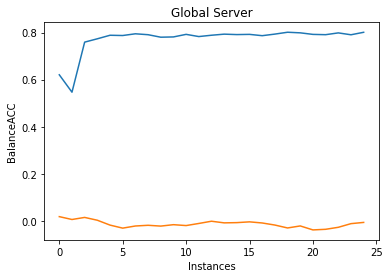

In [18]:
import math
import matplotlib.pyplot as plt
onn_network = global_network
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Gmean: " + str(math.sqrt(onn_network.sen*onn_network.spec)))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))
plt.plot(bal_acc_global)
plt.plot(stp_score_global)
plt.title('Global Server')
plt.xlabel('Instances')
plt.ylabel('BalanceACC')

In [16]:
print(stp_score_global)

[0.017683050585845406, 0.0055672497919279085, 0.014355460243671903, 0.0024062525817596936, -0.018255540057305758, -0.031149179030574625, -0.022073695282524286, -0.01905364912306784, -0.022489004420233605, -0.01648235094500755, -0.020239262253849588, -0.011323507182452341, -0.001804514104595617, -0.008757819619563845, -0.007758428792106115, -0.004463009610469748, -0.009236638891282456, -0.01803791923820769, -0.030431976691260354, -0.02181965819420828, -0.03872937520329717, -0.036116229555114454, -0.02761661675323146, -0.01207903684193623, -0.006849765797795504]


Balanced accuracy: 0.7920048309746728
Sensitivity: 0.8609370743666576
Specificity: 0.7230725875826881
Gmean: 0.7889993650873036
Stp score: -0.03496669837415012
Eqop score: -0.0456338152177761


Text(0, 0.5, 'BalanceACC')

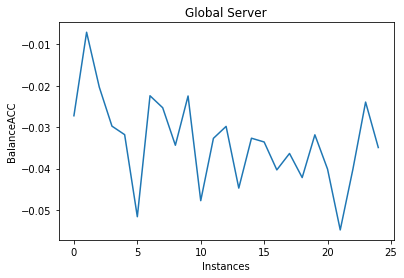

In [24]:
import math
import matplotlib.pyplot as plt
onn_network = global_network
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Gmean: " + str(math.sqrt(onn_network.sen*onn_network.spec)))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))
plt.plot(stp_score_global)
plt.title('Global Server')
plt.xlabel('Instances')
plt.ylabel('BalanceACC')

In [18]:
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Gmean: " + str(math.sqrt(onn_network.sen*onn_network.spec)))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))

Balanced accuracy: 0.7920048309746728
Sensitivity: 0.8609370743666576
Specificity: 0.7230725875826881
Gmean: 0.7889993650873036
Stp score: -0.03496669837415012
Eqop score: -0.0456338152177761


In [19]:
sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer = [],[],[],[]
sum_alpha = []
scaling_factor = 1/5
global_network2 = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
for m in range(3):
    if m==0:
        onn_network=onn_network_1
    elif m==1:
        onn_network=onn_network_2
    else:
        onn_network=onn_network_3
    if sum_alpha==[]:
        sum_alpha = torch.mul(client_alpha, scaling_factor)
        sum_w_output_layer = client_w_output_layer
        sum_b_output_layer = client_b_output_layer
        sum_w_hidden_layer = client_w_hidden_layer
        sum_b_hidden_layer = client_b_hidden_layer
            
        for j in range(onn_network.max_num_hidden_layers):
            sum_w_output_layer[j] = torch.mul(client_w_output_layer[j], scaling_factor)
            sum_b_output_layer[j] = torch.mul(client_b_output_layer[j], scaling_factor)
            sum_w_hidden_layer[j] = torch.mul(client_w_hidden_layer[j], scaling_factor)
            sum_b_hidden_layer[j] = torch.mul(client_b_hidden_layer[j], scaling_factor)

    else:
        sum_alpha = torch.add(sum_alpha, torch.mul(client_alpha, scaling_factor))
        for j in range(onn_network.max_num_hidden_layers):
            sum_w_output_layer[j] = torch.add(sum_w_output_layer[j],torch.mul(client_w_output_layer[j], scaling_factor)) 
            sum_b_output_layer[j] = torch.add(sum_b_output_layer[j],torch.mul(client_b_output_layer[j], scaling_factor))
            sum_w_hidden_layer[j] = torch.add(sum_w_hidden_layer[j],torch.mul(client_w_hidden_layer[j], scaling_factor)) 
            sum_b_hidden_layer[j] = torch.add(sum_b_hidden_layer[j],torch.mul(client_b_hidden_layer[j], scaling_factor))
        
        
global_network2.set_weights(sum_alpha, sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer)


In [20]:
onn_network_4 = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer = onn_network_3.get_weights('local')
onn_network_4.set_weights(galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer)